In [865]:
import shap
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import streamlit as st
import lightgbm as lgb
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import StandardScaler,MinMaxScaler,RobustScaler,QuantileTransformer
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier, StackingClassifier
from sklearn.metrics import accuracy_score, roc_auc_score,mean_squared_error, precision_score, recall_score,confusion_matrix,f1_score,r2_score,log_loss,brier_score_loss,classification_report, mean_absolute_error
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [653]:
shots = pd.read_excel("/Users/sp/Downloads/Dissertation/Datasets/shots_combined/shots_all_combined_v4.xlsx")
shots = shots.iloc[:, 1:]

In [656]:
shots.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 257800 entries, 0 to 257799
Data columns (total 87 columns):
 #   Column                                Non-Null Count   Dtype         
---  ------                                --------------   -----         
 0   id                                    257800 non-null  int64         
 1   minute                                257800 non-null  int64         
 2   result                                257800 non-null  object        
 3   X                                     257800 non-null  float64       
 4   Y                                     257800 non-null  float64       
 5   xG                                    257800 non-null  float64       
 6   player_striker                        257800 non-null  object        
 7   h_a                                   257800 non-null  object        
 8   player_id_striker                     257800 non-null  int64         
 9   situation                             257800 non-null  obje

In [363]:
# Function to process values in the column 'attacking_finishing_striker'
# The reason for this logic is that, in some cases, the data may contain values like '74+6' or '80-2'.
# This function processes the data as follows:
# - If the value is an integer, it returns it as is.
# - If the value contains a '-' (e.g., '80-2'), it splits the value, subtracts the second number from the first, and returns the result.
# - If the value contains a '+' (e.g., '74+6'), it splits the value, adds the two numbers together, and returns the result.
# - If none of the above cases apply, it converts the value to an integer.
def process_value(value):
    if isinstance(value, int):
        return value
    elif isinstance(value, str) and '-' in value:
        parts = value.split('-')
        return int(parts[0]) - int(parts[1])
    elif isinstance(value, str) and '+' in value:
        parts = value.split('+')
        return int(parts[0]) + int(parts[1])
    else:
        return int(value)
# Apply the function to the column
shots['attacking_finishing_striker'] = shots['attacking_finishing_striker'].apply(process_value)

In [96]:
shots.columns

Index(['id', 'minute', 'result', 'X', 'Y', 'xG', 'player_striker', 'h_a',
       'player_id_striker', 'situation', 'season', 'shotType', 'match_id',
       'h_goals', 'a_goals', 'date', 'player_assisted', 'lastAction',
       'league_name_striker', 'league_id_striker', 'corrected_home_team',
       'corrected_away_team', 'id_unique_striker', 'fifa_version_striker',
       'long_name_striker', 'overall_striker', 'potential_striker',
       'age_striker', 'height_cm_striker', 'weight_kg_striker',
       'club_position_striker', 'preferred_foot_striker', 'weak_foot_striker',
       'skill_moves_striker', 'international_reputation_striker',
       'attacking_finishing_striker', 'attacking_heading_accuracy_striker',
       'attacking_volleys_striker', 'skill_fk_accuracy_striker',
       'movement_agility_striker', 'movement_reactions_striker',
       'movement_balance_striker', 'power_shot_power_striker',
       'power_jumping_striker', 'power_stamina_striker',
       'power_long_shots_stri

In [ ]:
features = ['X', 'Y', 'Y_angle', 'is_Penalty', 'is_head', 'is_home', 'is_OpenPlay', 'is_DirectFreekick',
            'is_FromCorner', 'is_SetPiece', 'is_leading', 'is_lagging', 'is_tied', 'overall_striker',
            'Last_Action', 'attacking_finishing_striker', 'mentality_vision_striker',
            'power_long_shots_striker', 'overall_defence_team', 'defence_defence_team',
            'goalkeeping_reflexes_gk']

# Apply process_value to each feature column
for feature in features:
    shots[feature] = shots[feature].apply(process_value)

In [364]:
#shots.to_excel("/Users/sp/Downloads/Dissertation/Datasets/shots_combined/shots_all_combined_v4.xlsx")

In [97]:
target = shots['is_goal']
print("Feature Selection")


Feature Selection


In [529]:
entire_data = shots.loc[:, ['X', 'Y','is_goal']]

In [98]:
# Function to split the dataset into training and testing sets
# Uses stratified splitting to ensure the target class distribution is maintained in both sets
def testtrainsplit():
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42, stratify=target)
    print("Test Train Split")
    return X_train, X_test, y_train, y_test

print("Function for Test Train Split")

Function for Test Train Split


In [562]:
# Function to perform sampling on the training data to address class imbalance.
# This function uses a combination of SMOTE (Synthetic Minority Oversampling Technique) 
# and Tomek Links to balance the data, improving model performance for imbalanced datasets.
def sampling(X_train,y_train):
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
    print("Sampling")
    undersampler = TomekLinks(sampling_strategy='majority')
    X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train_resampled, y_train_resampled)
    return X_train_resampled,y_train_resampled

print("Function for Sampling")


Function for Sampling


In [563]:
# Function to scale the features using MinMaxScaler (or other scalers if desired)
# Applies scaling to the original training, resampled training, and testing sets for normalization
def scaling(X_train,X_train_resampled,X_test):
    scaler = MinMaxScaler()
    #scaler = RobustScaler()
    #scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_train_scaled_resampled = scaler.fit_transform(X_train_resampled)
    X_test_scaled = scaler.transform(X_test)
    X_data_scaled = scaler.transform(features)  
    print("Feature Scaling")
    return scaler,X_train_scaled,X_train_scaled_resampled,X_test_scaled,X_data_scaled

print("Function for Feature Scaling")

Function for Feature Scaling


In [564]:
# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = testtrainsplit()
# Applying oversampling
X_train_resampled,y_train_resampled = sampling(X_train,y_train)
# Standardizing the features using scaler
scaler,X_train_scaled,X_train_scaled_resampled,X_test_scaled,X_data_scaled = scaling(X_train,X_train_resampled,X_test)

Test Train Split
Sampling
Feature Scaling


In [565]:
# Function to train the model and predict outcomes
# Trains the given model on the training set and makes predictions on the test set
# Optionally, predicts on the entire dataset if 'is_pred_all_data' is True
def train_and_predict(model, X_train, y_train, X_test, X_data, is_pred_all_data):
    model.fit(X_train, y_train)
    y_predictions = model.predict(X_test)
    y_predictions_proba = model.predict_proba(X_test)[:, 1]
    if is_pred_all_data:
        xG_all = model.predict_proba(X_data_scaled)[:, 1]
        return model, y_predictions, y_predictions_proba, xG_all
    return y_predictions, y_predictions_proba

In [566]:
# Function for hyperparameter tuning using GridSearchCV
# It finds the best combination of hyperparameters for the given model based on the specified scoring metric (default 'roc_auc').
# The function uses cross-validation (cv=3) to evaluate model performance on different folds of the training data.
def hyperparameter_tuning(model, param_grid, X_train_scaled, y_train, scoring='roc_auc', cv=3, n_jobs=-1):
   
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv, scoring=scoring, n_jobs=n_jobs)
    grid_search.fit(X_train_scaled, y_train)
    
    best_params = grid_search.best_params_
    print("Best parameters:", best_params)
    
    #best_model = grid_search.best_estimator_
    
    return best_params

In [567]:
# Function to evaluate a model's performance and plot relevant metrics
# It computes various evaluation metrics such as accuracy, precision, recall, ROC AUC, F1 score, and log loss.
# Additionally, it compares the performance of the original model and the model after hyperparameter tuning
def evaluate_model_and_plot(y_test, y_pred, y_pred_proba,y_pred_hyper, y_pred_proba_hyper, name):
    
    print(f"Model Evaluation - {name}")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
    print(f"Precision: {precision_score(y_test, y_pred):.2f}")
    print(f"Recall: {recall_score(y_test, y_pred):.2f}")
    print(f"ROC AUC: {roc_auc_score(y_test, y_pred_proba):.2f}")
    print(f"Mean Squared Error: {mean_squared_error(y_test, y_pred):.2f}")
    print(f"F1 Score: {f1_score(y_test, y_pred):.2f}")
    print(f"Log Loss value: {log_loss(y_test, y_pred_proba):.2f}")
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print(f"Brier Score: {brier_score_loss(y_test, y_pred_proba):.2f}")

    print(f"\nHyperparameter Tuning Model Evaluation - {name}")
    print(f"Accuracy: {accuracy_score(y_test, y_pred_hyper):.2f}")
    print(f"Precision: {precision_score(y_test, y_pred_hyper):.2f}")
    print(f"Recall: {recall_score(y_test, y_pred_hyper):.2f}")
    print(f"ROC AUC: {roc_auc_score(y_test, y_pred_proba_hyper):.2f}")
    print(f"Mean Squared Error: {mean_squared_error(y_test, y_pred_hyper):.2f}")
    print(f"F1 Score: {f1_score(y_test, y_pred_hyper):.2f}")
    print(f"Log Loss value: {log_loss(y_test, y_pred_proba_hyper):.2f}")
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_hyper))
    print(f"Brier Score: {brier_score_loss(y_test, y_pred_proba_hyper):.2f}")

    #Scatter plot displaying xG values with respect to Angle of the goal and distance to the goal
    plt.figure(figsize=(10, 8))
# plt.scatter(data['X_coord'], data['Y_coord_angle'], c=data['xG_calc_LR'], cmap='coolwarm', s=50)
    plt.scatter(X_test['X'], X_test['Y'], c=y_pred_proba_hyper, cmap='coolwarm', s=50)
    plt.colorbar(label='xG (Expected Goals)')
    plt.xlabel('X Coordinate ')
    plt.ylabel('Y Coordinate')
    plt.title(f"xG Scatter Plot of {name}")
    plt.show()

In [568]:
#XGBoost Model

# Instantiate the XGBoost classifier
xgboost_classifier = XGBClassifier(random_state=42)


# Train the model on the resampled training set and predict on the test set
y_pred, y_pred_proba = train_and_predict(xgboost_classifier, X_train_scaled_resampled, y_train_resampled, X_test_scaled, X_data_scaled, 0)

print("xG Boost model Prediction")
#print(X_test['xG_calc'])

xG Boost model Prediction


In [569]:
param_grid = {
   'max_depth': [4, 6, 8, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 500, 1000]
}

# Perform hyperparameter tuning to find the best parameters for the XGBoost model
best_parameters = hyperparameter_tuning(XGBClassifier(random_state=42),param_grid, X_train_scaled_resampled,y_train_resampled)

Best parameters: {'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 500}


In [570]:
# Instantiate the final XGBoost model with the best hyperparameters
final_xgboost_model = XGBClassifier(**best_parameters, random_state=42)

# Train the tuned XGBoost model and make predictions on the test set and the entire dataset
final_xgboost_model,y_pred_hyper, y_pred_proba_hyper, xg_data = train_and_predict(final_xgboost, X_train_scaled_resampled, y_train_resampled, X_test_scaled, X_data_scaled, 1)

In [571]:
# Store the xG data for all shots in the dataset after prediction
entire_data['xG_XG'] = xg_data
X_test['xG_XG'] = y_pred_proba_hyper

Model Evaluation - XG BOOST
Accuracy: 0.91
Precision: 0.64
Recall: 0.22
ROC AUC: 0.80
Mean Squared Error: 0.09
F1 Score: 0.32
Log Loss value: 0.27
Confusion Matrix:
 [[45497   657]
 [ 4240  1166]]
Brier Score: 0.08

Hyperparameter Tuning Model Evaluation - XG BOOST
Accuracy: 0.90
Precision: 0.55
Recall: 0.29
ROC AUC: 0.80
Mean Squared Error: 0.10
F1 Score: 0.38
Log Loss value: 0.28
Confusion Matrix:
 [[44894  1260]
 [ 3850  1556]]
Brier Score: 0.08


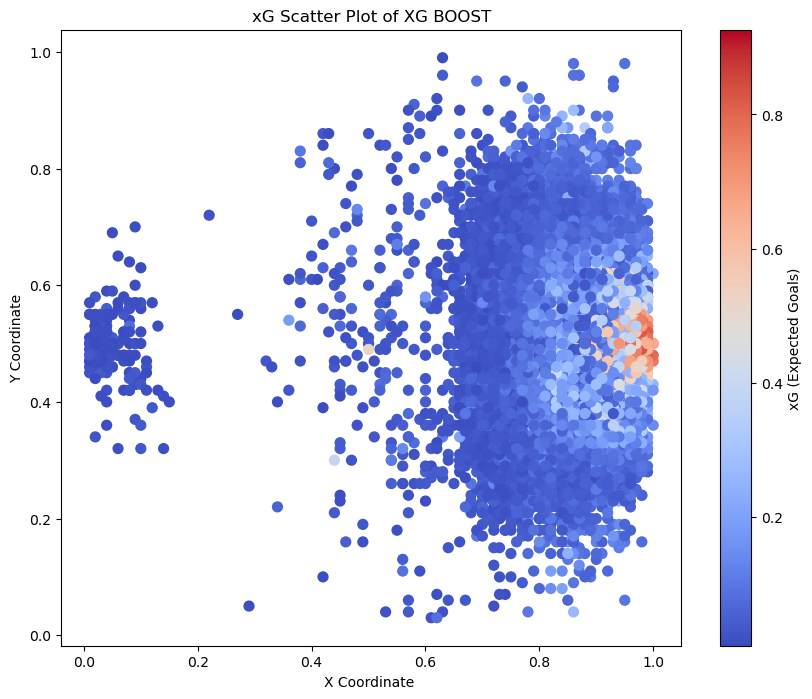

In [572]:
# Evaluate both the original and tuned models, and generate relevant plots
evaluate_model_and_plot(y_test, y_pred, y_pred_proba, y_pred_hyper, y_pred_proba_hyper, 'XG BOOST')

In [574]:
# Function to retrieve historical player features such as shooting power, height, etc.
# These features are computed as averages based on the player's past data and are used for xG predictions.
def get_historical_features(player_name):
    player_data = shots[shots['player_striker'] == player_name]
    
    historical_features = {
        'overall_striker_avg': player_data['overall_striker'].mean(),
        'power_long_shots_striker_avg': player_data['power_long_shots_striker'].mean(),
        'height_cm_striker_avg': player_data['height_cm_striker'].mean(),
        'mentality_vision_striker_avg': player_data['mentality_vision_striker'].mean(),
        'skill_fk_accuracy_striker_avg': player_data['skill_fk_accuracy_striker'].mean(),
        'attacking_finishing_striker_avg': player_data['attacking_finishing_striker'].mean()
    }
    
    return historical_features

# Function to calculate Expected Goals (xG) using various features and a machine learning model
def calculate_xG(model,position_x, position_y, Y_coord_angle, is_penalty, is_header, is_home, is_OpenPlay, is_DirectFreekick, is_FromCorner, is_SetPiece, is_leading, is_lagging, is_tied, player_name, Last_Action, Opponent_rating, overall_defence_team, goalkeeping_reflexes_gk):

    # Get historical features of the player from past performance data
    historical_features = get_historical_features(player_name)

    # Create a DataFrame with all the necessary features to predict xG
    new_data = pd.DataFrame({
        'X': [position_x],
        'Y': [position_y],
        'Y_angle': [Y_coord_angle],
        #'minute' : [minute],
        'is_Penalty': [is_penalty],
        'is_head': [is_header],
        'is_home': [is_home],
        'is_OpenPlay': [is_OpenPlay],
        'is_DirectFreekick': [is_DirectFreekick],
        'is_FromCorner': [is_FromCorner],
        'is_SetPiece': [is_SetPiece],
        'is_leading': [is_leading],
        'is_lagging': [is_lagging],
        'is_tied': [is_tied],
        'overall_striker': [historical_features['overall_striker_avg']],
        'Last_Action': [Last_Action],
        'power_long_shots_striker': [historical_features['power_long_shots_striker_avg']],
        'goalkeeping_reflexes_gk': [goalkeeping_reflexes_gk],
        'mentality_vision_striker': [historical_features['mentality_vision_striker_avg']],
        'attacking_finishing_striker': [historical_features['attacking_finishing_striker_avg']],
        'defence_defence_team': [Opponent_rating],
        'overall_defence_team': [overall_defence_team]
    })


    # Select the required features for model prediction
    features = new_data[['X', 'Y', 'Y_angle','is_Penalty', 'is_head', 'is_home', 'is_OpenPlay', 'is_DirectFreekick', 'is_FromCorner', 'is_SetPiece', 'is_leading', 'is_lagging', 'is_tied', 'overall_striker', 'Last_Action', 'attacking_finishing_striker', 'mentality_vision_striker', 'power_long_shots_striker', 'overall_defence_team', 'defence_defence_team', 'goalkeeping_reflexes_gk']]
    
    scaled_features = scaler.transform(features)
    #xg_prob = final_xgb_model.predict_proba(scaled_features)[:, 1]

    # Model prediction based on whether the model is an LSTM (Sequential) or a regular classifier
    if isinstance(model, Sequential):  # Check if the model is an LSTM model
        reshaped_features = scaled_features.reshape(scaled_features.shape[0], 1, scaled_features.shape[1])
        xg_prob = model.predict(reshaped_features)[:, 0]
    else:
        xg_prob = model.predict_proba(scaled_features)[:, 1]
       
    # Add the predicted xG value to the new data
    new_data['New xG'] = xg_prob
    
    return xg_prob[0], new_data

# Function to calculate xG for different scenarios like 'leading', 'lagging', and 'tied'
def calculate_xG_for_scenarios(model,player_name, base_params):

    # Define scenarios such as leading, lagging, or tied, with appropriate flag values
    scenarios = {
        'leading': {'is_leading': 1, 'is_lagging': 0, 'is_tied': 0},
        'lagging': {'is_leading': 0, 'is_lagging': 1, 'is_tied': 0},
        'tied': {'is_leading': 0, 'is_lagging': 0, 'is_tied': 1}
    }

    all_scenarios_xG_data = {}

    # Iterate through each scenario and calculate xG for the given player
    for scenario, values in scenarios.items():
        
        scenario_xG_data = pd.DataFrame(columns=['X', 'Y', 'Y_angle', 'is_Penalty', 'is_head', 'is_home', 'is_OpenPlay', 'is_DirectFreekick', 'is_FromCorner', 'is_SetPiece', 'is_leading', 'is_lagging', 'is_tied', 'overall_striker', 'Last_Action', 'attacking_finishing_striker', 'mentality_vision_striker', 'power_long_shots_striker', 'overall_defence_team', 'defence_defence_team', 'goalkeeping_reflexes_gk'])

        for params in base_params:
            modified_params = list(params)
            modified_params[10] = values['is_leading']
            modified_params[11] = values['is_lagging']
            modified_params[12] = values['is_tied']
            modified_params[13] = player_name
            
            xG_probability, new_data = calculate_xG(model,*modified_params)
            scenario_xG_data = pd.concat([scenario_xG_data, new_data], ignore_index=True)

        # Remove duplicates based on positional coordinates and angles
        scenario_xG_data = scenario_xG_data.drop_duplicates(subset=['X', 'Y', 'Y_angle'])
        all_scenarios_xG_data[scenario] = scenario_xG_data

    return all_scenarios_xG_data

# Function to create base parameters for xG calculation, including positions, angles, and other features
def prepare_base_params():
    base_params = [
        (0.88, 0.50, (1-abs(0.50-0.50)*2), 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, '', 10, 85, 75, 80),
        (0.90, 0.50, (1-abs(0.50-0.50)*2), 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, '', 10, 85, 75, 80),
        (0.94, 0.48, (1-abs(0.48-0.50)*2), 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, '', 10, 85, 75, 80),
        (0.90, 0.50, (1-abs(0.50-0.50)*2), 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, '', 10, 85, 75, 80),
        (0.95, 0.50, (1-abs(0.50-0.50)*2), 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, '', 10, 85, 75, 80),
        (0.87, 0.40, (1-abs(0.40-0.50)*2), 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, '', 10, 85, 75, 80),
        (0.80, 0.45, (1-abs(0.45-0.50)*2), 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, '', 10, 85, 75, 80),
        (0.50, 0.60, (1-abs(0.60-0.50)*2), 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, '', 10, 85, 75, 80),
        (0.40, 0.60, (1-abs(0.60-0.50)*2), 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, '', 10, 85, 75, 80),
        (0.60, 0.60, (1-abs(0.60-0.50)*2), 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, '', 10, 85, 75, 80),
        (0.70, 0.60, (1-abs(0.60-0.50)*2), 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, '', 10, 85, 75, 80),
        (0.75, 0.10, (1-abs(0.10-0.50)*2), 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, '', 10, 85, 75, 80)
    ]
    return base_params


In [575]:
# Define the XGBoost model to be used for xG prediction
xgboost_model = final_xgboost_model

In [576]:
# Prepare the base parameters for xG calculations
base_params = prepare_base_params()

# Define the player names for the xG calculations
player_name_messi = "Lionel Messi"
player_name_vincent = "Vincent Kompany"

# Calculate xG for different scenarios (leading, lagging, tied) for Messi
all_scenarios_xG_data_messi = calculate_xG_for_scenarios(xgboost_model,player_name_messi, base_params)

# Calculate xG for different scenarios (leading, lagging, tied) for Kompany
all_scenarios_xG_data_vincent = calculate_xG_for_scenarios(xgboost_model,player_name_vincent, base_params)

# Function to compare xG values for Messi and Kompany when their team is leading
def print_xG_values_leading(all_scenarios_xG_data_messi, all_scenarios_xG_data_vincent):
    scenario = 'leading'

    # Extract xG values for Messi and Kompany for the 'leading' scenario
    xG_data_messi = all_scenarios_xG_data_messi[scenario][["X", "Y", "Y_angle", "overall_striker", "New xG"]]
    xG_data_vincent = all_scenarios_xG_data_vincent[scenario][["overall_striker","New xG"]]

    # Rename columns to distinguish between Messi and Kompany
    xG_data_messi = xG_data_messi.rename(columns={"New xG": "xG_messi","overall_striker":"overall_striker_messi"})
    xG_data_vincent = xG_data_vincent.rename(columns={"New xG": "xG_vincent","overall_striker":"overall_striker_vincent"})

    # Combine the data
    combined_data = pd.concat([xG_data_messi.reset_index(drop=True), xG_data_vincent.reset_index(drop=True)], axis=1)
    
    print(f"xG values for scenario '{scenario}':")
    print(combined_data)
    print("\n")
    return combined_data

# Print xG values for leading scenario
overall_combined=print_xG_values_leading(all_scenarios_xG_data_messi, all_scenarios_xG_data_vincent)


/var/folders/d8/qbh4kpvx1070jvh0n_2l3jt40000gn/T/ipykernel_11706/2726130034.py:81: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  scenario_xG_data = pd.concat([scenario_xG_data, new_data], ignore_index=True)
/var/folders/d8/qbh4kpvx1070jvh0n_2l3jt40000gn/T/ipykernel_11706/2726130034.py:81: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  scenario_xG_data = pd.concat([scenario_xG_data, new_data], ignore_index=True)
/var/folders/d8/qbh4kpvx1070jvh0n_2l3jt40000gn/T/ipykernel_11706/2726130034.py:81: Fut

xG values for scenario 'leading':
       X     Y  Y_angle  overall_striker_messi  xG_messi  \
0   0.88  0.50     1.00              93.549035  0.455849   
1   0.90  0.50     1.00              93.549035  0.506764   
2   0.94  0.48     0.96              93.549035  0.746956   
3   0.95  0.50     1.00              93.549035  0.509857   
4   0.87  0.40     0.80              93.549035  0.245840   
5   0.80  0.45     0.90              93.549035  0.167167   
6   0.50  0.60     0.80              93.549035  0.089725   
7   0.40  0.60     0.80              93.549035  0.089725   
8   0.60  0.60     0.80              93.549035  0.089725   
9   0.70  0.60     0.80              93.549035  0.088042   
10  0.75  0.10     0.20              93.549035  0.096626   

    overall_striker_vincent  xG_vincent  
0                 85.282051    0.319864  
1                 85.282051    0.385248  
2                 85.282051    0.632670  
3                 85.282051    0.414786  
4                 85.282051    0.12

/var/folders/d8/qbh4kpvx1070jvh0n_2l3jt40000gn/T/ipykernel_11706/2726130034.py:81: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  scenario_xG_data = pd.concat([scenario_xG_data, new_data], ignore_index=True)
/var/folders/d8/qbh4kpvx1070jvh0n_2l3jt40000gn/T/ipykernel_11706/2726130034.py:81: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  scenario_xG_data = pd.concat([scenario_xG_data, new_data], ignore_index=True)


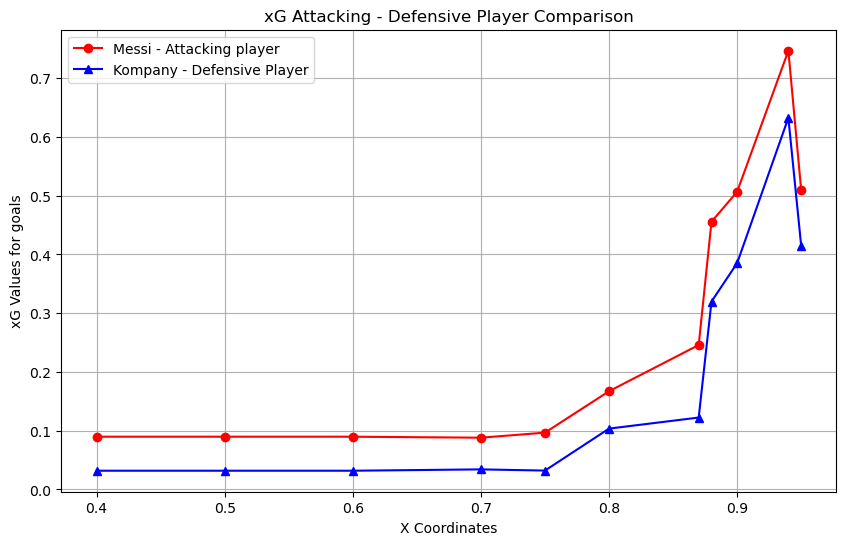

In [577]:
# Plot the comparison between Messi and Kompany's xG values in the 'leading' scenario
overall_combined.sort_values(by=["X", "Y"], inplace=True)
plt.figure(figsize=(10, 6))
plt.plot(overall_combined['X'], overall_combined['xG_messi'], label='Messi - Attacking player', color='red', marker='o')
plt.plot(overall_combined['X'], overall_combined['xG_vincent'], label='Kompany - Defensive Player', color='blue', marker='^')
# plt.plot(goal_df['X_coord'], goal_df['xG_calc_xgb'], label='xg_xgb', color='green', marker='s')

# Customizing the plot
plt.title('xG Attacking - Defensive Player Comparison')
plt.xlabel('X Coordinates')
plt.ylabel('xG Values for goals')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

In [578]:
# Function to combine Messi's xG values for all scenarios (leading, lagging, tied) into a single DataFrame
def combine_messi_xG_values(all_scenarios_xG_data_messi):
    combined_data = pd.DataFrame()

    # Iterate over the scenarios and combine the xG values into a single DataFrame
    for scenario, data in all_scenarios_xG_data_messi.items():
        if not data.empty and 'New xG' in data.columns:
            xG_data = data[["X", "Y", "Y_angle", "overall_striker", "New xG"]].copy()
            xG_data = xG_data.rename(columns={"New xG": f"xG_{scenario}"})
            
            if combined_data.empty:
                combined_data = xG_data
            else:
                combined_data = pd.merge(combined_data, xG_data, on=["X", "Y", "Y_angle", "overall_striker"], how="outer")
        else:
            print(f"Warning: No data or missing 'New xG' column for scenario '{scenario}'")
    return combined_data

# Combine Messi's xG values for all scenarios (leading, lagging, tied)
combined_messi_xG_values = combine_messi_xG_values(all_scenarios_xG_data_messi)

In [579]:
# Print the combined DataFrame
print(combined_messi_xG_values)

       X     Y  Y_angle  overall_striker  xG_leading  xG_lagging   xG_tied
0   0.40  0.60     0.80        93.549035    0.089725    0.040954  0.062576
1   0.50  0.60     0.80        93.549035    0.089725    0.040954  0.062576
2   0.60  0.60     0.80        93.549035    0.089725    0.040954  0.062576
3   0.70  0.60     0.80        93.549035    0.088042    0.040954  0.062576
4   0.75  0.10     0.20        93.549035    0.096626    0.044942  0.054805
5   0.80  0.45     0.90        93.549035    0.167167    0.096652  0.102928
6   0.87  0.40     0.80        93.549035    0.245840    0.169253  0.180922
7   0.88  0.50     1.00        93.549035    0.455849    0.203060  0.326362
8   0.90  0.50     1.00        93.549035    0.506764    0.247441  0.360842
9   0.94  0.48     0.96        93.549035    0.746956    0.664599  0.690843
10  0.95  0.50     1.00        93.549035    0.509857    0.391256  0.451490


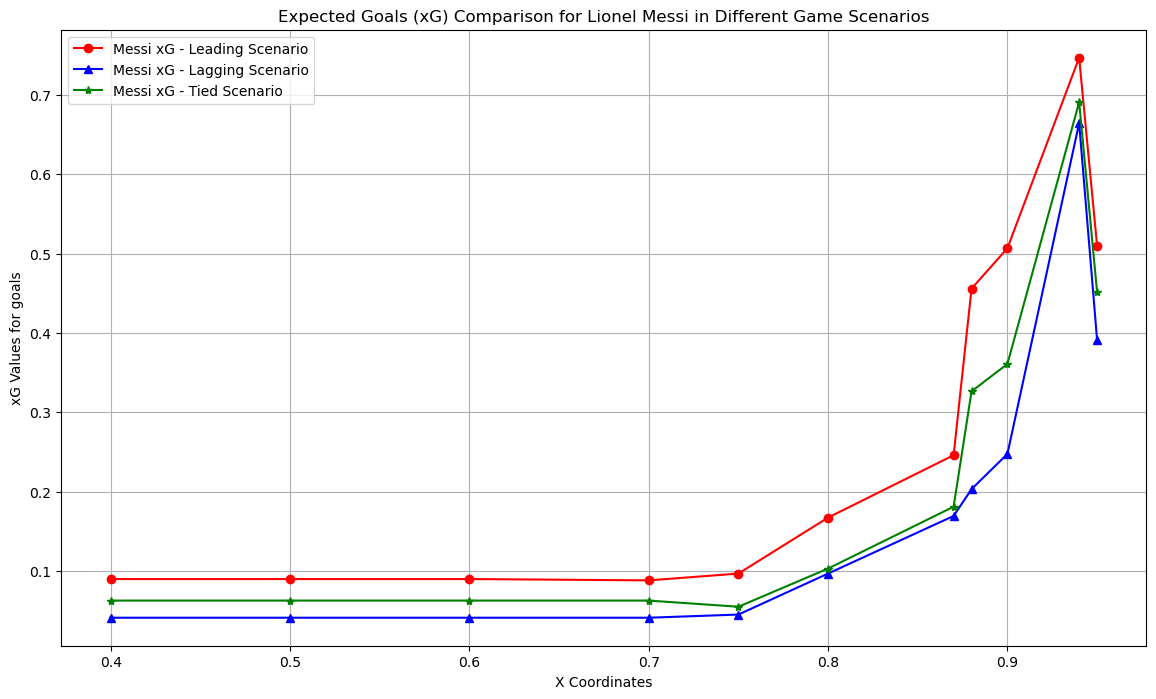

In [580]:
# Plot the combined xG values for Messi across different game scenarios
combined_messi_xG_values.sort_values(by=["X", "Y"], inplace=True)
plt.figure(figsize=(14, 8))
plt.plot(combined_messi_xG_values['X'], combined_messi_xG_values['xG_leading'], label='Messi xG - Leading Scenario', color='red', marker='o')
plt.plot(combined_messi_xG_values['X'], combined_messi_xG_values['xG_lagging'], label='Messi xG - Lagging Scenario', color='blue', marker='^')
plt.plot(combined_messi_xG_values['X'], combined_messi_xG_values['xG_tied'], label='Messi xG - Tied Scenario', color='green', marker='*')
# plt.plot(goal_df['X_coord'], goal_df['xG_calc_xgb'], label='xg_xgb', color='green', marker='s')

# Customizing the plot
plt.title('Expected Goals (xG) Comparison for Lionel Messi in Different Game Scenarios')
plt.xlabel('X Coordinates')
plt.ylabel('xG Values for goals')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

In [581]:
player_name = "Lionel Messi"

In [582]:
# Function to calculate xG values when facing an opponent team based on different skill levels
def calculate_xG_for_opponent(model, player_name, opponent_name, opponent_rating,gk_reflex):
    new_xG_data = pd.DataFrame(columns=['X', 'Y', 'Y_angle', 'is_Penalty', 'is_head', 'is_home', 'is_OpenPlay',
                                        'is_DirectFreekick', 'is_FromCorner', 'is_SetPiece', 'is_leading', 'is_lagging',
                                        'is_tied', 'overall_striker', 'Last_Action', 'attacking_finishing_striker',
                                        'mentality_vision_striker', 'power_long_shots_striker', 'overall_defence_team',
                                        'defence_defence_team', 'goalkeeping_reflexes_gk'])

    # Different shot parameters to simulate multiple scenarios
    parameter_sets = [
        (0.88, 0.50, (1 - abs(0.50 - 0.50) * 2), 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, player_name, 10, opponent_rating, opponent_rating, gk_reflex),
        (0.90, 0.50, (1 - abs(0.50 - 0.50) * 2), 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, player_name, 10, opponent_rating, opponent_rating, gk_reflex),
        (0.94, 0.48, (1 - abs(0.48 - 0.50) * 2), 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, player_name, 10, opponent_rating, opponent_rating, gk_reflex),
        (0.90, 0.50, (1 - abs(0.50 - 0.50) * 2),0, 0, 0, 1, 0, 0, 0, 1, 0, 0, player_name, 10, opponent_rating, opponent_rating, gk_reflex),
        (0.95, 0.50, (1 - abs(0.50 - 0.50) * 2), 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, player_name, 10, opponent_rating, opponent_rating, gk_reflex),
        (0.87, 0.40, (1 - abs(0.40 - 0.50) * 2), 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, player_name, 10, opponent_rating, opponent_rating, gk_reflex),
        (0.80, 0.45, (1 - abs(0.45 - 0.50) * 2), 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, player_name, 10, opponent_rating, opponent_rating, gk_reflex),
        (0.50, 0.50, (1 - abs(0.50 - 0.50) * 2), 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, player_name, 10, opponent_rating, opponent_rating, gk_reflex),
        (0.40, 0.60, (1 - abs(0.60 - 0.50) * 2), 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, player_name, 10, opponent_rating, opponent_rating, gk_reflex),
        (0.60, 0.60, (1 - abs(0.60 - 0.50) * 2), 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, player_name, 10, opponent_rating, opponent_rating, gk_reflex),
        (0.70, 0.60, (1 - abs(0.60 - 0.50) * 2), 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, player_name, 10, opponent_rating, opponent_rating, gk_reflex),
        (0.75, 0.10, (1 - abs(0.10 - 0.50) * 2), 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, player_name, 10, opponent_rating, opponent_rating, gk_reflex)
    ]

    for params in parameter_sets:
        xG_probability, new_data = calculate_xG(model, *params)
        new_xG_data = pd.concat([new_xG_data, new_data], ignore_index=True)
        
    new_xG_data = new_xG_data.drop_duplicates(subset=['X', 'Y', 'Y_angle'])

    return new_xG_data


# Calculate xG for Messi when facing a low-rated team like Sunderland
opponent_name_sunderland = "Sunderland"
opponent_rating_sunderland = 65
gk_reflex_sunderland = 68
sunderland_xG_data = calculate_xG_for_opponent(xgboost_model,player_name, opponent_name_sunderland, opponent_rating_sunderland,gk_reflex_sunderland)

# Print xG values for Sunderland scenario
print(f"xG values when Messi takes a shot against low rated teams such as {opponent_name_sunderland}")
print(sunderland_xG_data[["X", "Y", "Y_angle", "overall_striker", "overall_defence_team", "New xG"]])

# Calculate xG for Messi when facing a high-rated team like Real Madrid
opponent_name_realmadrid = "Real Madrid"
opponent_rating_realmadrid = 85
gk_reflex_realmadrid = 88

realmadrid_xG_data = calculate_xG_for_opponent(xgboost_model,player_name, opponent_name_realmadrid, opponent_rating_realmadrid,gk_reflex_realmadrid)

# Print xG values for Real Madrid scenario
print(f"xG values when Messi takes a shot against high rated teams such as {opponent_name_realmadrid}")
print(realmadrid_xG_data[["X", "Y", "Y_angle", "overall_striker", "overall_defence_team", "New xG"]])

# Combine xG data for Messi against different teams
all_opponent_xG_data_messi = {
    opponent_name_sunderland: sunderland_xG_data,
    opponent_name_realmadrid: realmadrid_xG_data
}

# Display combined xG values for each team
for opponent, xG_data in all_opponent_xG_data_messi.items():
    print(f"xG values for Messi against {opponent}:")
    print(xG_data)
    print("\n")

/var/folders/d8/qbh4kpvx1070jvh0n_2l3jt40000gn/T/ipykernel_11706/1934510249.py:25: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  new_xG_data = pd.concat([new_xG_data, new_data], ignore_index=True)
/var/folders/d8/qbh4kpvx1070jvh0n_2l3jt40000gn/T/ipykernel_11706/1934510249.py:25: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  new_xG_data = pd.concat([new_xG_data, new_data], ignore_index=True)


xG values when Messi takes a shot against low rated teams such as Sunderland
       X     Y  Y_angle  overall_striker overall_defence_team    New xG
0   0.88  0.50     1.00        93.549035                   65  0.588076
1   0.90  0.50     1.00        93.549035                   65  0.537433
2   0.94  0.48     0.96        93.549035                   65  0.769255
4   0.95  0.50     1.00        93.549035                   65  0.519094
5   0.87  0.40     0.80        93.549035                   65  0.289630
6   0.80  0.45     0.90        93.549035                   65  0.250830
7   0.50  0.50     1.00        93.549035                   65  0.108194
8   0.40  0.60     0.80        93.549035                   65  0.109331
9   0.60  0.60     0.80        93.549035                   65  0.109331
10  0.70  0.60     0.80        93.549035                   65  0.109331
11  0.75  0.10     0.20        93.549035                   65  0.128470
xG values when Messi takes a shot against high rated teams 

In [583]:
# Combine xG values for Messi across teams for visualization
teams_messi_xG_values = combine_messi_xG_values(all_opponent_xG_data_messi)
teams_messi_xG_values

X     Y  Y_angle  overall_striker  xG_Sunderland  xG_Real Madrid
0   0.40  0.60     0.80        93.549035       0.109331        0.070473
1   0.50  0.50     1.00        93.549035       0.108194        0.060451
2   0.60  0.60     0.80        93.549035       0.109331        0.070473
3   0.70  0.60     0.80        93.549035       0.109331        0.061953
4   0.75  0.10     0.20        93.549035       0.128470        0.086990
5   0.80  0.45     0.90        93.549035       0.250830        0.139474
6   0.87  0.40     0.80        93.549035       0.289630        0.199844
7   0.88  0.50     1.00        93.549035       0.588076        0.399412
8   0.90  0.50     1.00        93.549035       0.537433        0.440879
9   0.94  0.48     0.96        93.549035       0.769255        0.700211
10  0.95  0.50     1.00        93.549035       0.519094        0.431832

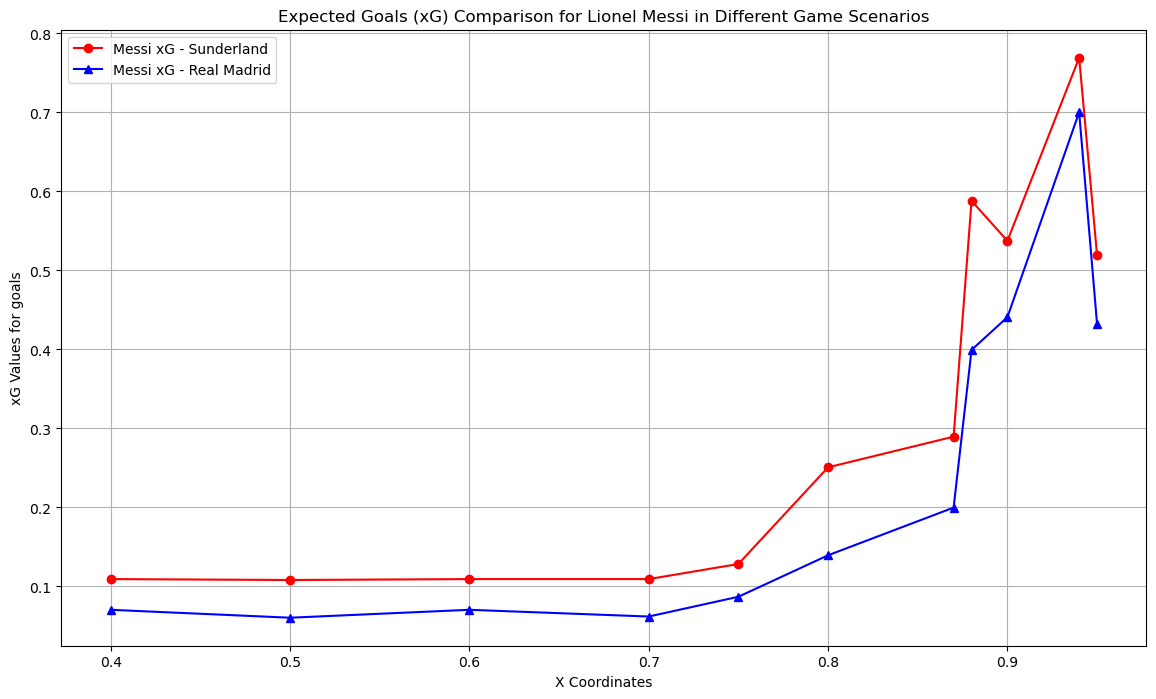

In [584]:
# Plot comparison of xG values for Messi against Sunderland and Real Madrid
teams_messi_xG_values.sort_values(by=["X", "Y"], inplace=True)
plt.figure(figsize=(14, 8))
plt.plot(teams_messi_xG_values['X'], teams_messi_xG_values['xG_Sunderland'], label='Messi xG - Sunderland', color='red', marker='o')
plt.plot(teams_messi_xG_values['X'], teams_messi_xG_values['xG_Real Madrid'], label='Messi xG - Real Madrid', color='blue', marker='^')
# plt.plot(goal_df['X_coord'], goal_df['xG_calc_xgb'], label='xg_xgb', color='green', marker='s')

# Customize the plot
plt.title('Expected Goals (xG) Comparison for Lionel Messi in Different Game Scenarios')
plt.xlabel('X Coordinates')
plt.ylabel('xG Values for goals')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

In [585]:
# Combine xG values for Messi across teams for visualization
teams_messi_xG_values = combine_messi_xG_values(all_opponent_xG_data_messi)
teams_messi_xG_values

X     Y  Y_angle  overall_striker  xG_Sunderland  xG_Real Madrid
0   0.40  0.60     0.80        93.549035       0.109331        0.070473
1   0.50  0.50     1.00        93.549035       0.108194        0.060451
2   0.60  0.60     0.80        93.549035       0.109331        0.070473
3   0.70  0.60     0.80        93.549035       0.109331        0.061953
4   0.75  0.10     0.20        93.549035       0.128470        0.086990
5   0.80  0.45     0.90        93.549035       0.250830        0.139474
6   0.87  0.40     0.80        93.549035       0.289630        0.199844
7   0.88  0.50     1.00        93.549035       0.588076        0.399412
8   0.90  0.50     1.00        93.549035       0.537433        0.440879
9   0.94  0.48     0.96        93.549035       0.769255        0.700211
10  0.95  0.50     1.00        93.549035       0.519094        0.431832

In [586]:
# Function to calculate xG based on different shot types (e.g., header vs. foot)
def calculate_xG_for_shot_type(model, player_name, shot_type, opponent_rating,opponent_defence):
    new_xG_data = pd.DataFrame(columns=['X', 'Y', 'Y_angle', 'is_Penalty', 'is_head', 'is_home', 'is_OpenPlay',
                                        'is_DirectFreekick', 'is_FromCorner', 'is_SetPiece', 'is_leading', 'is_lagging',
                                        'is_tied', 'overall_striker', 'Last_Action', 'attacking_finishing_striker',
                                        'mentality_vision_striker', 'power_long_shots_striker', 'overall_defence_team',
                                        'defence_defence_team', 'goalkeeping_reflexes_gk'])

    # Determine if the shot is a header or not
    is_head = 1 if shot_type == "head" else 0

    # Different shot parameters for varying scenarios and shot types
    parameter_sets = [
        (0.85, 0.49, (1 - abs(0.50 - 0.50) * 2), 0, is_head, 1, 1, 0, 0, 0, 1, 0, 0, player_name, 10, opponent_rating, opponent_defence, 80),
        (0.90, 0.50, (1 - abs(0.50 - 0.50) * 2), 0, is_head, 1, 1, 0, 0, 0, 1, 0, 0, player_name, 10, opponent_rating, opponent_defence, 80),
        (0.94, 0.48, (1 - abs(0.48 - 0.50) * 2), 0, is_head, 1, 1, 0, 0, 0, 1, 0, 0, player_name, 10, opponent_rating, opponent_defence, 80),
        (0.90, 0.50, (1 - abs(0.50 - 0.50) * 2), 0, is_head, 0, 1, 0, 0, 0, 1, 0, 0, player_name, 10, opponent_rating, opponent_defence, 80),
        (0.95, 0.50, (1 - abs(0.50 - 0.50) * 2), 0, is_head, 1, 1, 0, 0, 0, 1, 0, 0, player_name, 10, opponent_rating, opponent_defence, 80),
        (0.87, 0.40, (1 - abs(0.40 - 0.50) * 2), 0, is_head, 1, 1, 0, 0, 0, 1, 0, 0, player_name, 10, opponent_rating, opponent_defence, 80),
        (0.81, 0.30, (1 - abs(0.30 - 0.50) * 2), 0, is_head, 1, 1, 0, 0, 0, 1, 0, 0, player_name, 10, opponent_rating, opponent_defence, 80),
        (0.83, 0.48, (1 - abs(0.48 - 0.50) * 2), 0, is_head, 1, 1, 0, 0, 0, 1, 0, 0, player_name, 10, opponent_rating, opponent_defence, 80)
    ]

    # Calculate xG for each shot type scenario
    for params in parameter_sets:
        xG_probability, new_data = calculate_xG(model, *params)
        new_xG_data = pd.concat([new_xG_data, new_data], ignore_index=True)

    return new_xG_data

In [587]:
# Example usage: Calculate xG for Messi's header and foot shots
player_name = "Lionel Messi"
shot_header = 'head'
shot_foot = 'foot'
opponent_defence = 75  # Example rating for Sunderland
opponent_rating = 80  # Example rating for Real Madrid

# Calculate xG for header and foot shots
head_xG_data = calculate_xG_for_shot_type(xgboost_model,player_name, shot_header, opponent_rating,opponent_defence)
foot_xG_data = calculate_xG_for_shot_type(xgboost_model,player_name, shot_foot, opponent_rating,opponent_defence)

# Combine xG values for different shot types
all_shot_xG_data_messi = {
    shot_header: head_xG_data,
    shot_foot: foot_xG_data
}

# Combine the xG values for Messi's different shot types
shot_messi_xG_values = combine_messi_xG_values(all_shot_xG_data_messi)
shot_messi_xG_values


/var/folders/d8/qbh4kpvx1070jvh0n_2l3jt40000gn/T/ipykernel_11706/1020586848.py:23: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  new_xG_data = pd.concat([new_xG_data, new_data], ignore_index=True)
/var/folders/d8/qbh4kpvx1070jvh0n_2l3jt40000gn/T/ipykernel_11706/1020586848.py:23: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  new_xG_data = pd.concat([new_xG_data, new_data], ignore_index=True)


X     Y  Y_angle  overall_striker   xG_head   xG_foot
0  0.81  0.30     0.60        93.549035  0.124834  0.124834
1  0.83  0.48     0.96        93.549035  0.131493  0.316914
2  0.85  0.49     1.00        93.549035  0.153921  0.274525
3  0.87  0.40     0.80        93.549035  0.117547  0.221342
4  0.90  0.50     1.00        93.549035  0.155460  0.504956
5  0.90  0.50     1.00        93.549035  0.155460  0.555619
6  0.90  0.50     1.00        93.549035  0.155750  0.504956
7  0.90  0.50     1.00        93.549035  0.155750  0.555619
8  0.94  0.48     0.96        93.549035  0.398660  0.753189
9  0.95  0.50     1.00        93.549035  0.503776  0.727418

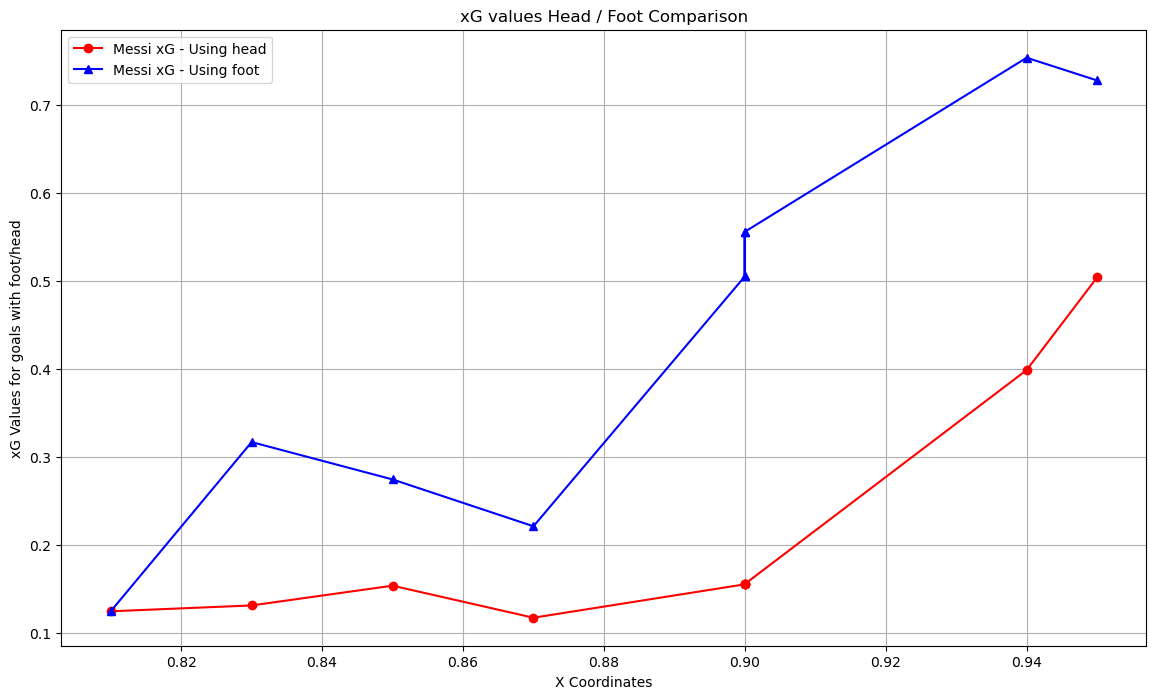

In [588]:
# Plot xG comparison between head and foot shots for Messi
shot_messi_xG_values.sort_values(by=["X", "Y"], inplace=True)
plt.figure(figsize=(14, 8))
plt.plot(shot_messi_xG_values['X'], shot_messi_xG_values['xG_head'], label='Messi xG - Using head', color='red', marker='o')
plt.plot(shot_messi_xG_values['X'], shot_messi_xG_values['xG_foot'], label='Messi xG - Using foot', color='blue', marker='^')
# plt.plot(goal_df['X_coord'], goal_df['xG_calc_xgb'], label='xg_xgb', color='green', marker='s')

# Customize plot with titles, labels, and legend
plt.title('xG values Head / Foot Comparison')
plt.xlabel('X Coordinates')
plt.ylabel('xG Values for goals with foot/head')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

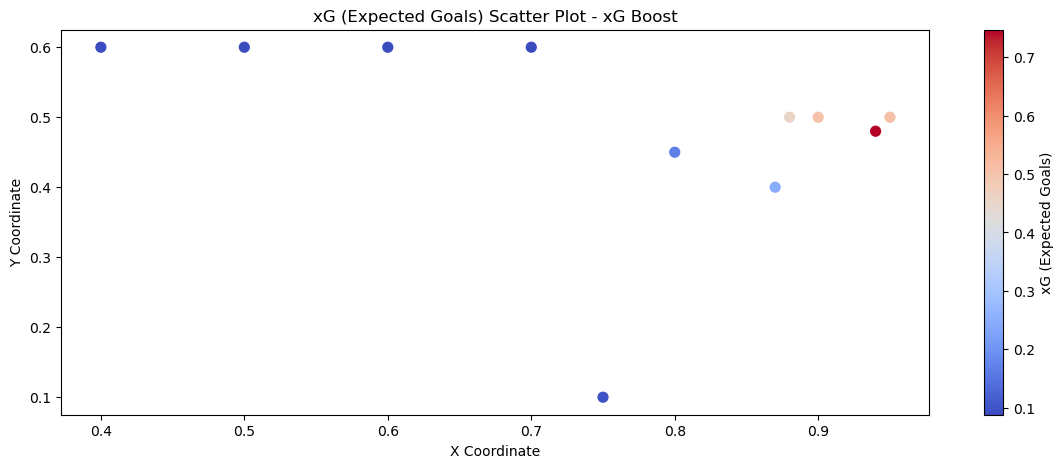

In [589]:
# Create scatter plot showing xG values for Messi in different game scenarios (leading scenario example)
plt.figure(figsize=(14, 5))
plt.scatter(combined_messi_xG_values['X'], combined_messi_xG_values['Y'], c=combined_messi_xG_values['xG_leading'], cmap='coolwarm', s=50)
plt.colorbar(label='xG (Expected Goals)')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('xG (Expected Goals) Scatter Plot - xG Boost')
plt.show()

In [914]:
# Function to plot xG values on a football pitch using xGBoost predictions
def plot_football_pitch(X_data):
    # Create the pitch using the 'Pitch' object from the `mplsoccer` library
    pitch = Pitch(pitch_color='grass', stripe=True, pitch_type='wyscout', line_color='white', goal_type='box', label=True, axis=True, tick=True)
    fig, ax = pitch.draw(figsize=(18, 8))
    
    # Plot xG values on the football pitch as scatter points with color based on xG values
    sc = ax.scatter(X_data['X'] * 100, X_data['Y'] * 100, c=X_data['xG_XG'], cmap='coolwarm', s=50, edgecolors='black', alpha=0.7)
    
    # Set the axis limits and labels
    ax.set_xlim(0, 100)
    ax.set_ylim(0, 100)
    ax.set_xlabel('X Coordinate')
    ax.set_ylabel('Y Coordinate')
    ax.set_title('xG Representation on Football Pitch using XGBoost')
    
    # Add colorbar
    cbar = plt.colorbar(sc, ax=ax)
    cbar.set_label('xG (Expected Goals)')
    
    # Invert y-axis to match the football pitch perspective
    plt.gca().invert_yaxis()
    
    plt.show()


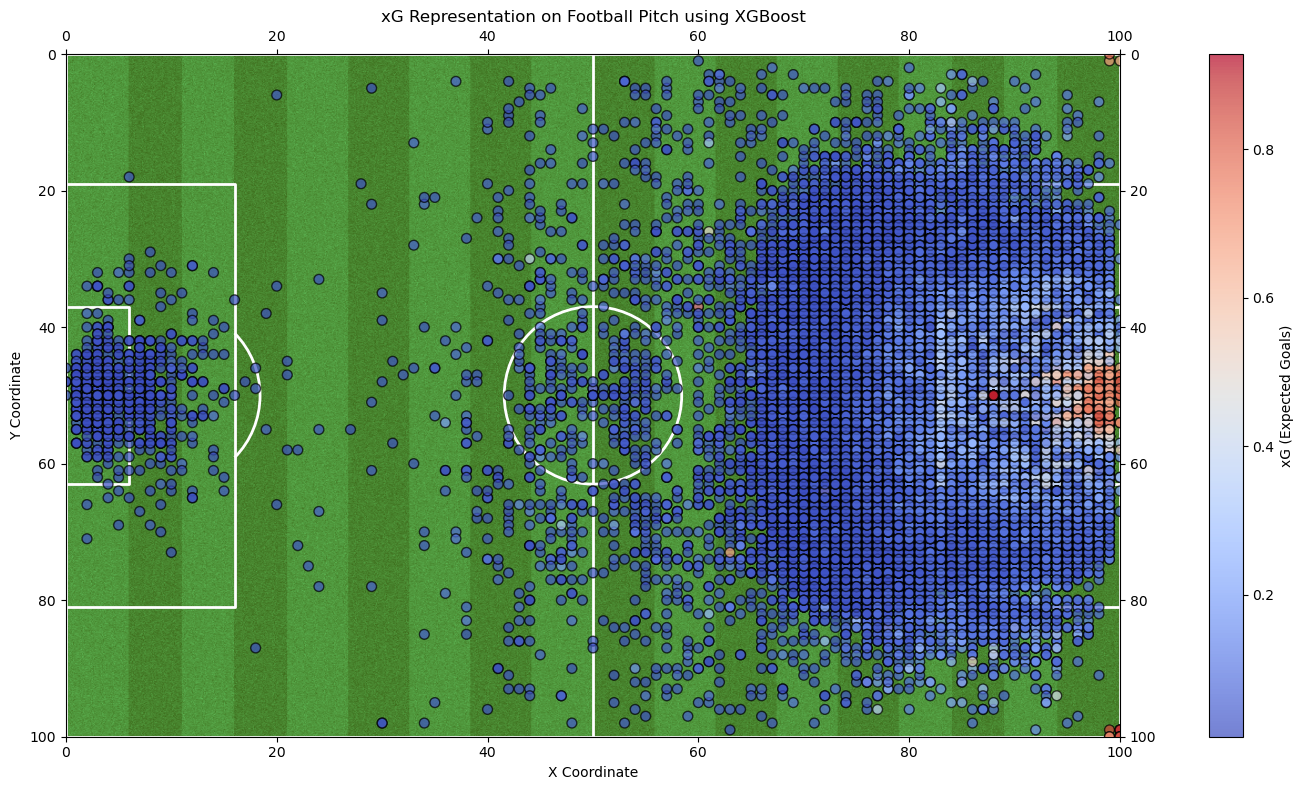

In [915]:
# Plot the football pitch with xG values for test data
plot_football_pitch(entire_data)

In [592]:
#LOGISTIC_REGRESSION

Logistic Regression model Prediction


/Users/sp/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/sp/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/sp/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/sp/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/sp/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/sp/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:34

Best parameters: {'C': 1, 'penalty': 'l1', 'solver': 'saga'}
Model Evaluation - LOGISTIC REGRESSION
Accuracy: 0.86
Precision: 0.36
Recall: 0.41
ROC AUC: 0.78
Mean Squared Error: 0.14
F1 Score: 0.38
Log Loss value: 0.34
Confusion Matrix:
 [[42223  3931]
 [ 3210  2196]]
Brier Score: 0.10

Hyperparameter Tuning Model Evaluation - LOGISTIC REGRESSION
Accuracy: 0.90
Precision: 0.76
Recall: 0.13
ROC AUC: 0.79
Mean Squared Error: 0.10
F1 Score: 0.22
Log Loss value: 0.27
Confusion Matrix:
 [[45936   218]
 [ 4718   688]]
Brier Score: 0.08


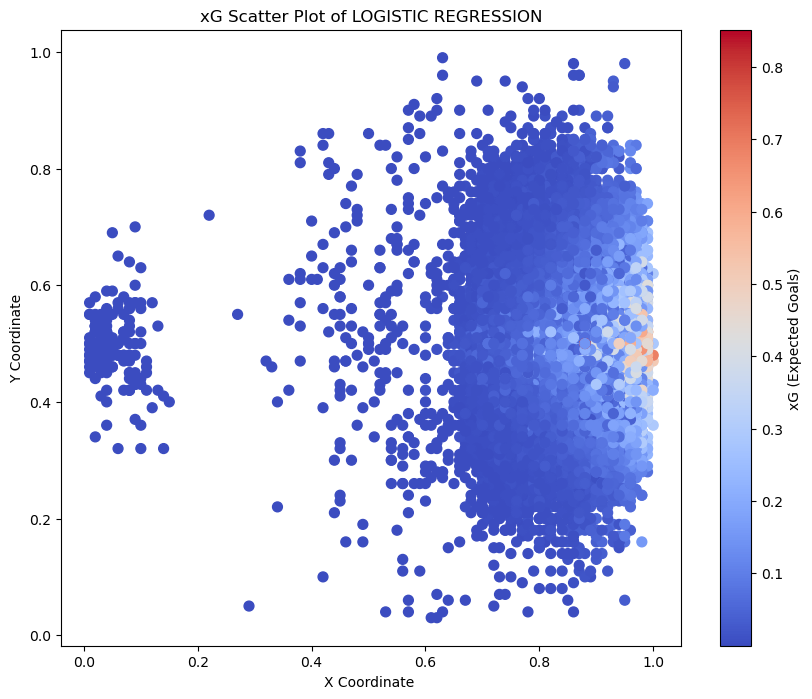

In [877]:
# Train and evaluate a Logistic Regression model

# Initialize the logistic regression model

logistic_model = LogisticRegression(random_state=42)

# Train the model and make predictions on the test data
y_pred, y_pred_proba = train_and_predict(logistic_model, X_train_scaled_resampled, y_train_resampled, X_test_scaled, X_data_scaled, 0)

print("Logistic Regression model Prediction")

# Define the hyperparameter grid for tuning the logistic regression model
param_grid = {
   'C': [0.01, 0.1, 1, 10, 50, 100],
        'penalty': ['l1','l2'],
        'solver': [ 'saga']  # Add the solver compatible with l1 penalty
}

# Perform hyperparameter tuning using GridSearchCV
best_parameters = hyperparameter_tuning(LogisticRegression(random_state=42),param_grid, X_train_scaled,y_train)

# Initialize and train the final logistic regression model using the best hyperparameters
final_logistic_model = LogisticRegression(**best_parameters,max_iter=1000, random_state=42)
final_logistic_model,y_pred_hyper, y_pred_proba_hyper, xg_data = train_and_predict(final_logistic_model, X_train_scaled, y_train, X_test_scaled, X_data_scaled, 1)


# Add predicted xG values from the logistic regression model to the data
entire_data['xG_LR'] = xg_data
X_test['xG_LR'] = y_pred_proba_hyper

# Evaluate and plot the performance of the logistic regression model
evaluate_model_and_plot(y_test, y_pred, y_pred_proba, y_pred_hyper, y_pred_proba_hyper, 'LOGISTIC REGRESSION')

In [878]:
# Store the final logistic regression model for future predictions
logistic_model = final_logistic_model

In [879]:
# Calculate xG for Lionel Messi using the logistic regression model across different game scenarios
logistic_xG_data_messi = calculate_xG_for_scenarios(logistic_model,player_name_messi, base_params)

/var/folders/d8/qbh4kpvx1070jvh0n_2l3jt40000gn/T/ipykernel_11706/2726130034.py:81: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  scenario_xG_data = pd.concat([scenario_xG_data, new_data], ignore_index=True)
/var/folders/d8/qbh4kpvx1070jvh0n_2l3jt40000gn/T/ipykernel_11706/2726130034.py:81: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  scenario_xG_data = pd.concat([scenario_xG_data, new_data], ignore_index=True)
/var/folders/d8/qbh4kpvx1070jvh0n_2l3jt40000gn/T/ipykernel_11706/2726130034.py:81: Fut

In [880]:
logistic_xG_data_messi

{'leading':        X     Y  Y_angle is_Penalty is_head is_home is_OpenPlay  \
 0   0.88  0.50     1.00          0       0       1           1   
 1   0.90  0.50     1.00          0       0       1           1   
 2   0.94  0.48     0.96          0       0       1           1   
 4   0.95  0.50     1.00          0       1       1           1   
 5   0.87  0.40     0.80          0       0       1           1   
 6   0.80  0.45     0.90          0       0       1           1   
 7   0.50  0.60     0.80          0       0       1           1   
 8   0.40  0.60     0.80          0       0       1           1   
 9   0.60  0.60     0.80          0       0       1           1   
 10  0.70  0.60     0.80          0       0       1           1   
 11  0.75  0.10     0.20          0       0       1           1   
 
    is_DirectFreekick is_FromCorner is_SetPiece  ... is_tied overall_striker  \
 0                  0             0           0  ...       0       93.549035   
 1                  0  

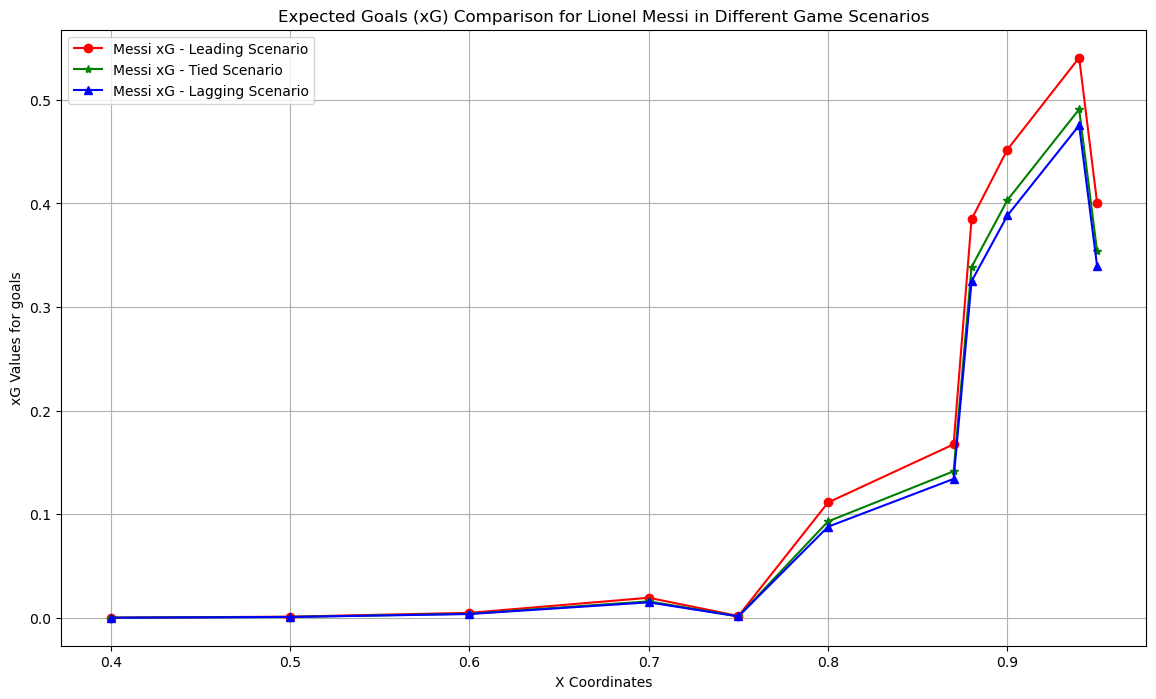

In [881]:
# Combine Messi's xG values across different game scenarios for easy comparison
combined_messi_xG_values_logistic = combine_messi_xG_values(logistic_xG_data_messi)

# Sort the combined xG values by X and Y coordinates for better plotting
combined_messi_xG_values_logistic.sort_values(by=["X", "Y"], inplace=True)

# Plot the xG values for Messi in different scenarios (leading, tied, lagging) using logistic regression
plt.figure(figsize=(14, 8))
plt.plot(combined_messi_xG_values_logistic['X'], combined_messi_xG_values_logistic['xG_leading'], label='Messi xG - Leading Scenario', color='red', marker='o')
plt.plot(combined_messi_xG_values_logistic['X'], combined_messi_xG_values_logistic['xG_tied'], label='Messi xG - Tied Scenario', color='green', marker='*')
plt.plot(combined_messi_xG_values_logistic['X'], combined_messi_xG_values_logistic['xG_lagging'], label='Messi xG - Lagging Scenario', color='blue', marker='^')

# plt.plot(goal_df['X_coord'], goal_df['xG_calc_xgb'], label='xg_xgb', color='green', marker='s')

# Customize the plot with titles, labels, legend, and grid
plt.title('Expected Goals (xG) Comparison for Lionel Messi in Different Game Scenarios')
plt.xlabel('X Coordinates')
plt.ylabel('xG Values for goals')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

In [598]:
combined_messi_xG_values_logistic

X     Y  Y_angle  overall_striker  xG_leading  xG_lagging   xG_tied
0   0.40  0.60     0.80        93.549035    0.000453    0.000273  0.000405
1   0.50  0.60     0.80        93.549035    0.002083    0.001254  0.001862
2   0.60  0.60     0.80        93.549035    0.009517    0.005745  0.008514
3   0.70  0.60     0.80        93.549035    0.042363    0.025913  0.038030
4   0.75  0.10     0.20        93.549035    0.002979    0.001794  0.002663
5   0.80  0.45     0.90        93.549035    0.255912    0.171380  0.235101
6   0.87  0.40     0.80        93.549035    0.361833    0.254269  0.336301
7   0.88  0.50     1.00        93.549035    0.673286    0.553428  0.648096
8   0.90  0.50     1.00        93.549035    0.736617    0.627126  0.714238
9   0.94  0.48     0.96        93.549035    0.804025    0.711585  0.785708
10  0.95  0.50     1.00        93.549035    0.532091    0.406124  0.504034

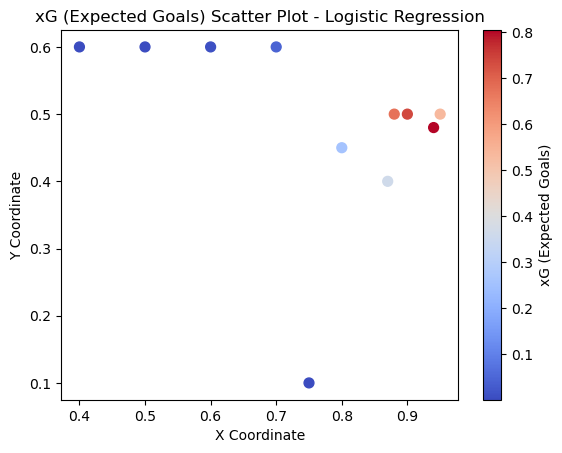

In [599]:
# Create a scatter plot showing Messi's xG values (leading scenario) with X and Y coordinates using logistic regression
plt.scatter(combined_messi_xG_values_logistic['X'], combined_messi_xG_values_logistic['Y'], c=combined_messi_xG_values_logistic['xG_leading'], cmap='coolwarm', s=50)
plt.colorbar(label='xG (Expected Goals)')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('xG (Expected Goals) Scatter Plot - Logistic Regression')
plt.show()

Random Forest model Prediction
Best parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Model Evaluation - Random Forest
Accuracy: 0.90
Precision: 0.51
Recall: 0.25
ROC AUC: 0.78
Mean Squared Error: 0.10
F1 Score: 0.34
Log Loss value: 0.32
Confusion Matrix:
 [[44857  1297]
 [ 4030  1376]]
Brier Score: 0.09

Hyperparameter Tuning Model Evaluation - Random Forest
Accuracy: 0.90
Precision: 0.52
Recall: 0.26
ROC AUC: 0.79
Mean Squared Error: 0.10
F1 Score: 0.34
Log Loss value: 0.29
Confusion Matrix:
 [[44871  1283]
 [ 4024  1382]]
Brier Score: 0.08


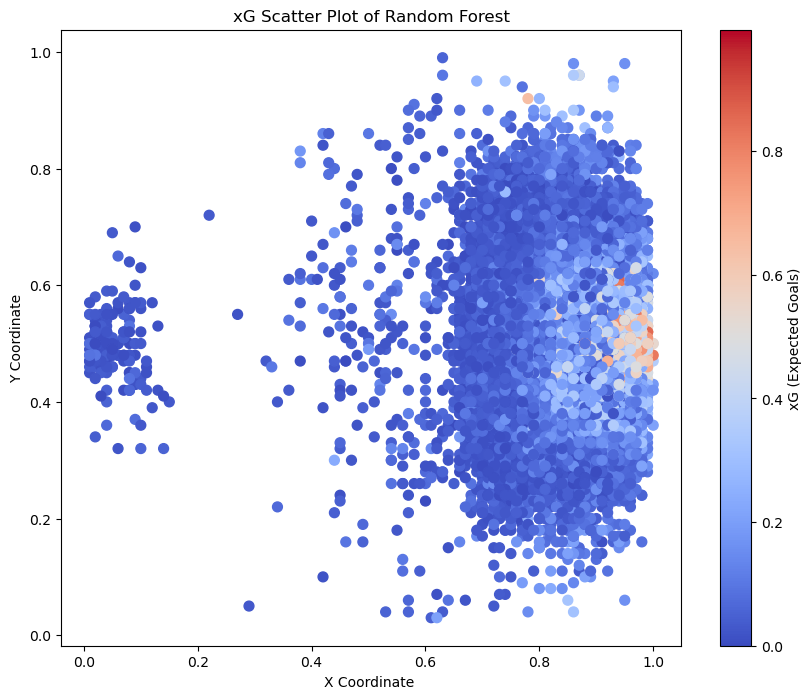

In [600]:
# Train a Random Forest model to predict xG values

# Initialize the Random Forest model with a random state for reproducibility
rf_model = RandomForestClassifier(random_state=42)

# Train the Random Forest model and make predictions on the test data
y_pred, y_pred_proba = train_and_predict(rf_model, X_train_scaled_resampled, y_train_resampled, X_test_scaled, X_data_scaled, 0)

print("Random Forest model Prediction")

# Define hyperparameter grid for tuning the Random Forest model
param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 10],
        'min_samples_split': [2, 3, 5],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt', 'log2']  # Removed 'auto'
    }

# Perform hyperparameter tuning using GridSearchCV for Random Forest
best_parameters = hyperparameter_tuning(RandomForestClassifier(random_state=42),param_grid, X_train_scaled_resampled,y_train_resampled)

# Train the final Random Forest model using the best hyperparameters
final_rf_model = RandomForestClassifier(**best_parameters, random_state=42)
final_rf_model,y_pred_hyper, y_pred_proba_hyper, xg_data = train_and_predict(final_rf_model, X_train_scaled_resampled, y_train_resampled, X_test_scaled, X_data_scaled, 1)

# Store the predicted xG values for the entire data and test set for analysis
entire_data['xG_RF'] = xg_data
X_test['xG_RF'] = y_pred_proba_hyper

# Evaluate the Random Forest model and plot the evaluation metrics
evaluate_model_and_plot(y_test, y_pred, y_pred_proba, y_pred_hyper, y_pred_proba_hyper, 'Random Forest')

In [601]:
# Store the final Random Forest model for future predictions
rand_forest_model = final_rf_model

In [602]:
# Calculate xG values for Lionel Messi using the Random Forest model across different game scenarios
r_f_xG_data_messi = calculate_xG_for_scenarios(rand_forest_model,player_name_messi, base_params)

/var/folders/d8/qbh4kpvx1070jvh0n_2l3jt40000gn/T/ipykernel_11706/2726130034.py:81: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  scenario_xG_data = pd.concat([scenario_xG_data, new_data], ignore_index=True)
/var/folders/d8/qbh4kpvx1070jvh0n_2l3jt40000gn/T/ipykernel_11706/2726130034.py:81: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  scenario_xG_data = pd.concat([scenario_xG_data, new_data], ignore_index=True)
/var/folders/d8/qbh4kpvx1070jvh0n_2l3jt40000gn/T/ipykernel_11706/2726130034.py:81: Fut

In [603]:
r_f_xG_data_messi

{'leading':        X     Y  Y_angle is_Penalty is_head is_home is_OpenPlay  \
 0   0.88  0.50     1.00          0       0       1           1   
 1   0.90  0.50     1.00          0       0       1           1   
 2   0.94  0.48     0.96          0       0       1           1   
 4   0.95  0.50     1.00          0       1       1           1   
 5   0.87  0.40     0.80          0       0       1           1   
 6   0.80  0.45     0.90          0       0       1           1   
 7   0.50  0.60     0.80          0       0       1           1   
 8   0.40  0.60     0.80          0       0       1           1   
 9   0.60  0.60     0.80          0       0       1           1   
 10  0.70  0.60     0.80          0       0       1           1   
 11  0.75  0.10     0.20          0       0       1           1   
 
    is_DirectFreekick is_FromCorner is_SetPiece  ... is_tied overall_striker  \
 0                  0             0           0  ...       0       93.549035   
 1                  0  

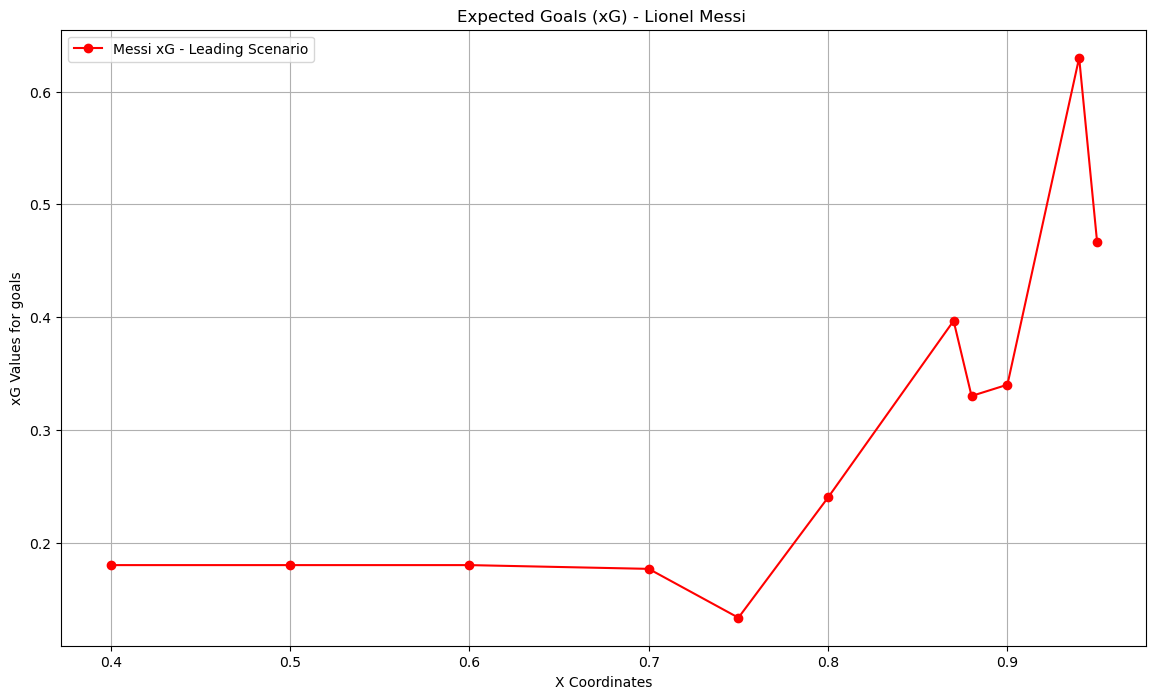

In [657]:
# Combine Messi's xG values across different game scenarios for easy comparison (Random Forest model)
combined_messi_xG_values_r_f = combine_messi_xG_values(r_f_xG_data_messi)

# Sort the combined xG values by X and Y coordinates for better plotting
combined_messi_xG_values_r_f.sort_values(by=["X", "Y"], inplace=True)

# Plot the xG values for Messi (leading scenario) using Random Forest
plt.figure(figsize=(14, 8))
plt.plot(combined_messi_xG_values_r_f['X'], combined_messi_xG_values_r_f['xG_leading'], label='Messi xG - Leading Scenario', color='red', marker='o')
# plt.plot(goal_df['X_coord'], goal_df['xG_calc_xgb'], label='xg_xgb', color='green', marker='s')

# Customizing the plot
plt.title('Expected Goals (xG) - Lionel Messi ')
plt.xlabel('X Coordinates')
plt.ylabel('xG Values for goals')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

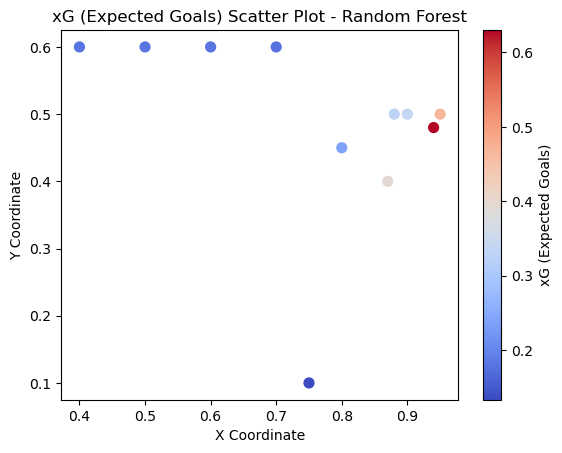

In [605]:
# Create a scatter plot showing Messi's xG values (leading scenario) using Random Forest model
plt.scatter(combined_messi_xG_values_r_f['X'], combined_messi_xG_values_r_f['Y'], c=combined_messi_xG_values_r_f['xG_leading'], cmap='coolwarm', s=50)
plt.colorbar(label='xG (Expected Goals)')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('xG (Expected Goals) Scatter Plot - Random Forest')
plt.show()

In [606]:
#Artificial Neural Network

In [882]:
print("Keras ANN Model Prediction")

# Define a Keras Sequential Artificial Neural Network (ANN) model with two hidden layers
ann_model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train_scaled_resampled.shape[1],)),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

# Compile the ANN model with Adam optimizer, binary cross-entropy loss, and accuracy as a metric
ann_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Fit the model using the resampled training data for 50 epochs
ann_model.fit(X_train_scaled_resampled, y_train_resampled, epochs=50, batch_size=32, verbose=1)

# Generate probability predictions for the test set
y_pred_proba = ann_model.predict(X_test_scaled)
X_test['xG_ANN'] = y_pred


Keras ANN Model Prediction
Epoch 1/50
11413/11413 [==============================] - 4s 327us/step - loss: 0.3069 - accuracy: 0.8588
Epoch 2/50
11413/11413 [==============================] - 4s 310us/step - loss: 0.2944 - accuracy: 0.8648
Epoch 3/50
11413/11413 [==============================] - 4s 310us/step - loss: 0.2891 - accuracy: 0.8678
Epoch 4/50
11413/11413 [==============================] - 4s 315us/step - loss: 0.2854 - accuracy: 0.8703
Epoch 5/50
11413/11413 [==============================] - 4s 311us/step - loss: 0.2824 - accuracy: 0.8719
Epoch 6/50
11413/11413 [==============================] - 4s 315us/step - loss: 0.2797 - accuracy: 0.8730
Epoch 7/50
11413/11413 [==============================] - 4s 332us/step - loss: 0.2782 - accuracy: 0.8744
Epoch 8/50
11413/11413 [==============================] - 3s 293us/step - loss: 0.2763 - accuracy: 0.8755
Epoch 9/50
11413/11413 [==============================] - 3s 294us/step - loss: 0.2747 - accuracy: 0.8765
Epoch 10/50
11413/1

Best parameters: {'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (64, 32), 'max_iter': 500}
Model Evaluation - Artificial Neural Network
Accuracy: 0.89
Precision: 0.44
Recall: 0.33
ROC AUC: 0.79
Mean Squared Error: 0.11
F1 Score: 0.38
Log Loss value: 0.30
Confusion Matrix:
 [[43825  2329]
 [ 3595  1811]]
Brier Score: 0.09

Hyperparameter Tuning Model Evaluation - Artificial Neural Network
Accuracy: 0.91
Precision: 0.67
Recall: 0.19
ROC AUC: 0.81
Mean Squared Error: 0.09
F1 Score: 0.30
Log Loss value: 0.27
Confusion Matrix:
 [[45639   515]
 [ 4366  1040]]
Brier Score: 0.08


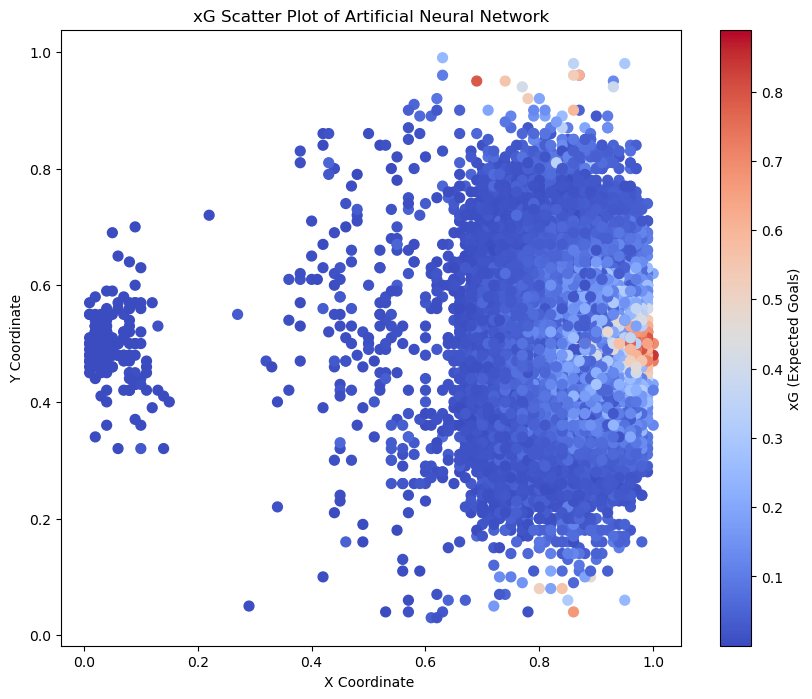

In [893]:
# Binarize the predictions for classification metrics evaluation (threshold at 0.5)
y_pred = (y_pred_proba > 0.5).astype(int).flatten()

# Initialize a Scikit-learn MLPClassifier model for ANN with hyperparameter tuning
ann_sklearn = MLPClassifier(random_state=42)


# Define hyperparameter grid for tuning the Scikit-learn MLPClassifier model
param_grid_ann = {
    'hidden_layer_sizes': [ (64,32), (50, 50), (50,30,10)],
    'alpha': [ 0.0001, 0.001, 0.01],
    'activation': ['relu','logistic'],
    'max_iter': [200, 500]
}

# Perform hyperparameter tuning using the hyperparameter_tuning function
best_parameters_ann = hyperparameter_tuning(ann_sklearn, param_grid_ann, X_train_scaled, y_train)

# Train the best ANN model found by GridSearchCV
best_ann_model = MLPClassifier(**best_parameters_ann, random_state=42)
best_ann_model.fit(X_train_scaled, y_train)

# Generate probability predictions and class predictions for the test set using the best model
hyper_preds_proba = best_ann_model.predict_proba(X_test_scaled)[:, 1]
hyper_preds = best_ann_model.predict(X_test_scaled)

# Evaluate and plot the performance of the ANN model
evaluate_model_and_plot(y_test, y_pred, y_pred_proba, hyper_preds, hyper_preds_proba, 'Artificial Neural Network')

In [894]:
# Store the xG predictions for the ANN model in the test set
X_test['xG_ANN'] = hyper_preds_proba

In [895]:
a_n_n_model = best_ann_model

In [891]:
# Calculate xG for Lionel Messi in different game scenarios using the Keras ANN model
ann_xG_data_messi = calculate_xG_for_scenarios(a_n_n_model,player_name_messi, base_params)

/var/folders/d8/qbh4kpvx1070jvh0n_2l3jt40000gn/T/ipykernel_11706/2726130034.py:81: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  scenario_xG_data = pd.concat([scenario_xG_data, new_data], ignore_index=True)
/var/folders/d8/qbh4kpvx1070jvh0n_2l3jt40000gn/T/ipykernel_11706/2726130034.py:81: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  scenario_xG_data = pd.concat([scenario_xG_data, new_data], ignore_index=True)
/var/folders/d8/qbh4kpvx1070jvh0n_2l3jt40000gn/T/ipykernel_11706/2726130034.py:81: Fut

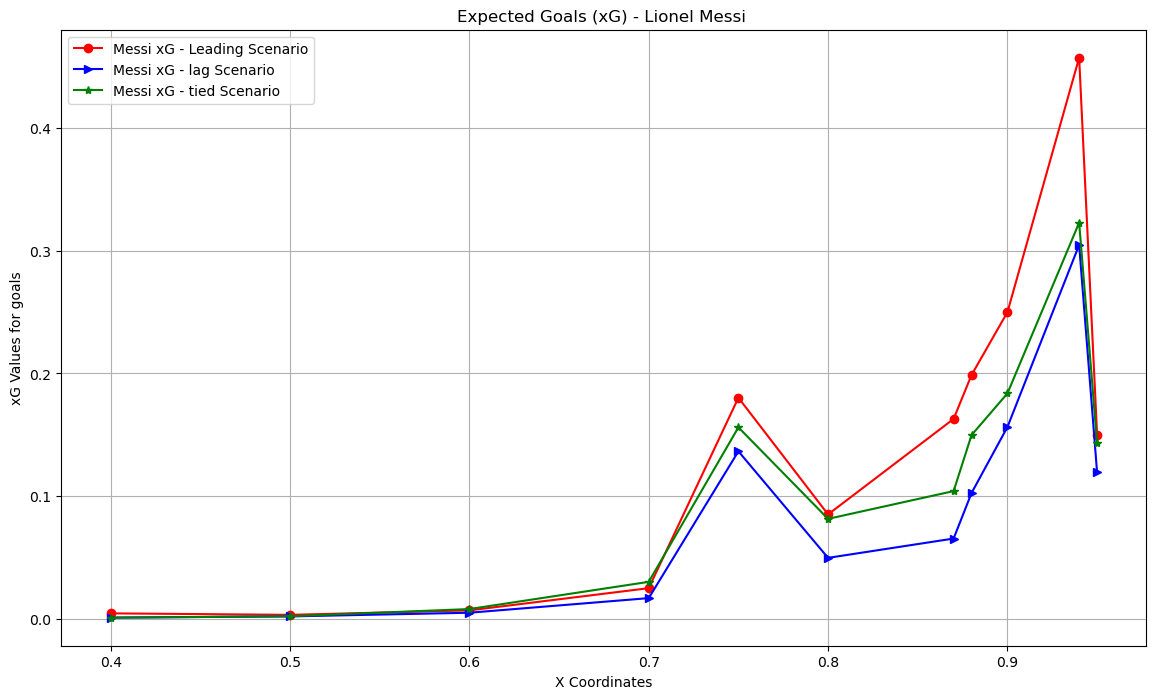

In [892]:
# Combine Messi's xG values across different game scenarios for comparison
combined_messi_xG_values_ann = combine_messi_xG_values(ann_xG_data_messi)

# Sort the combined xG values for better plotting
combined_messi_xG_values_ann.sort_values(by=["X", "Y"], inplace=True)

# Plot Messi's xG values for leading, lagging, and tied scenarios using the Keras ANN model
plt.figure(figsize=(14, 8))
plt.plot(combined_messi_xG_values_ann['X'], combined_messi_xG_values_ann['xG_leading'], label='Messi xG - Leading Scenario', color='red', marker='o')
plt.plot(combined_messi_xG_values_ann['X'], combined_messi_xG_values_ann['xG_lagging'], label='Messi xG - lag Scenario', color='blue', marker='>')
plt.plot(combined_messi_xG_values_ann['X'], combined_messi_xG_values_ann['xG_tied'], label='Messi xG - tied Scenario', color='green', marker='*')

# plt.plot(goal_df['X_coord'], goal_df['xG_calc_xgb'], label='xg_xgb', color='green', marker='s')

# Customizing the plot
plt.title('Expected Goals (xG) - Lionel Messi ')
plt.xlabel('X Coordinates')
plt.ylabel('xG Values for goals')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

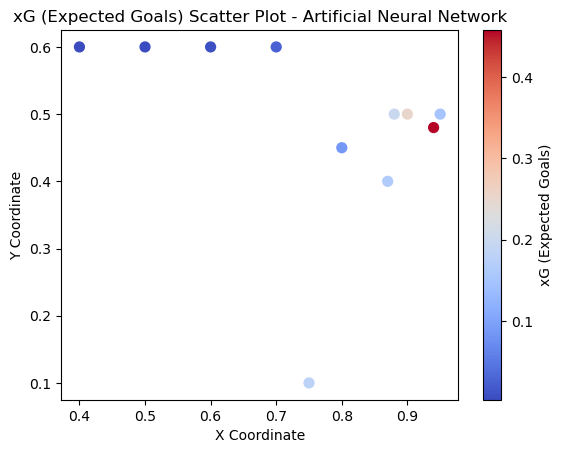

In [814]:
# Create a scatter plot showing Messi's xG values (leading scenario) using the Keras ANN model
plt.scatter(combined_messi_xG_values_ann['X'], combined_messi_xG_values_ann['Y'], c=combined_messi_xG_values_ann['xG_leading'], cmap='coolwarm', s=50)
plt.colorbar(label='xG (Expected Goals)')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('xG (Expected Goals) Scatter Plot - Artificial Neural Network')
plt.show()

[LightGBM] [Info] Number of positive: 184616, number of negative: 180591
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005597 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1174
[LightGBM] [Info] Number of data points in the train set: 365207, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505511 -> initscore=0.022043
[LightGBM] [Info] Start training from score 0.022043
Light Gradient Boost model Prediction


/Users/sp/anaconda3/lib/python3.11/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(
/Users/sp/anaconda3/lib/python3.11/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(
/Users/sp/anaconda3/lib/python3.11/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix t

[LightGBM] [Info] Number of positive: 184616, number of negative: 180591
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003061 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1174
[LightGBM] [Info] Number of data points in the train set: 365207, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505511 -> initscore=0.022043
[LightGBM] [Info] Start training from score 0.022043
Best parameters: {'learning_rate': 0.1, 'max_depth': 10, 'num_leaves': 100}
[LightGBM] [Info] Number of positive: 184616, number of negative: 180591
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003430 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1174
[LightGBM] [Info] Number of data

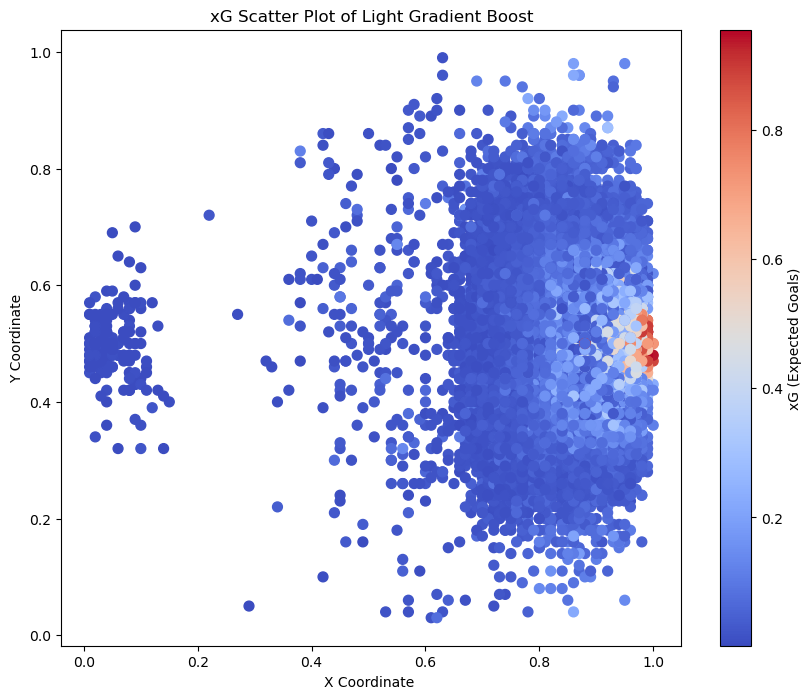

In [614]:
# Train and evaluate the LightGBM model

# Initialize the LightGBM model
lgb_model = lgb.LGBMClassifier(random_state=42)

# Train the model and make predictions on the test set
y_pred, y_pred_proba = train_and_predict(lgb_model, X_train_scaled_resampled, y_train_resampled, X_test_scaled, X_data_scaled, 0)

print("Light Gradient Boost model Prediction")

# Define hyperparameter grid for tuning the LightGBM model
param_grid = {
        'num_leaves': [31, 50, 100],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [10, 20],  # -1 indicates no limit (default value)
        #'n_estimators': [100, 200, 300],
        #'class_weight': [None, 'balanced']
    }

# Perform hyperparameter tuning using the hyperparameter_tuning function
best_parameters = hyperparameter_tuning(lgb.LGBMClassifier(random_state=42),param_grid, X_train_scaled_resampled,y_train_resampled)

# Train the final LightGBM model with the best hyperparameters
final_lgb_model = lgb.LGBMClassifier(**best_parameters, random_state=42)
final_lgb_model,y_pred_hyper, y_pred_proba_hyper, xg_data = train_and_predict(final_lgb_model, X_train_scaled_resampled, y_train_resampled, X_test_scaled, X_data_scaled, 1)

# Store the xG predictions for the LightGBM model in the test set and entire dataset
entire_data['xG_LGB'] = xg_data
X_test['xG_LGB'] = y_pred_proba_hyper

# Evaluate and plot the performance of the LightGBM model
evaluate_model_and_plot(y_test, y_pred, y_pred_proba, y_pred_hyper, y_pred_proba_hyper, 'Light Gradient Boost')

In [615]:
lgb_model = final_lgb_model

/var/folders/d8/qbh4kpvx1070jvh0n_2l3jt40000gn/T/ipykernel_11706/2726130034.py:81: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  scenario_xG_data = pd.concat([scenario_xG_data, new_data], ignore_index=True)
/var/folders/d8/qbh4kpvx1070jvh0n_2l3jt40000gn/T/ipykernel_11706/2726130034.py:81: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  scenario_xG_data = pd.concat([scenario_xG_data, new_data], ignore_index=True)
/var/folders/d8/qbh4kpvx1070jvh0n_2l3jt40000gn/T/ipykernel_11706/2726130034.py:81: Fut

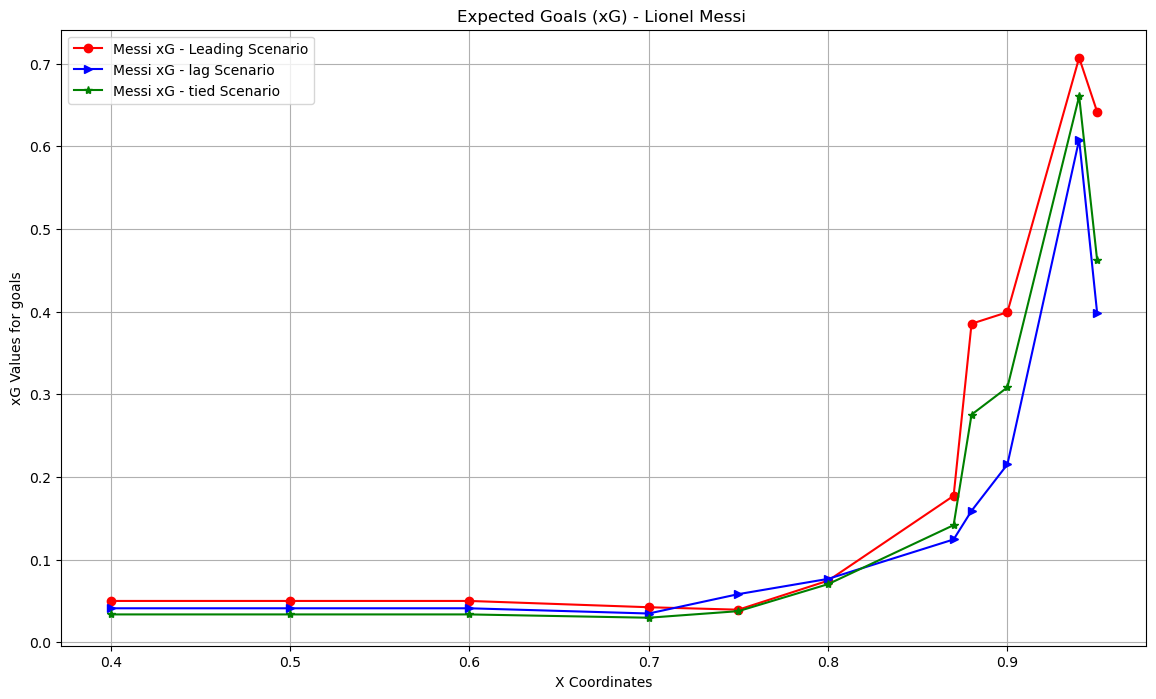

In [616]:
# Calculate xG for Lionel Messi in different game scenarios using the LightGBM model
lgb_xG_data_messi = calculate_xG_for_scenarios(lgb_model,player_name_messi, base_params)

# Combine Messi's xG values across different game scenarios for comparison
combined_messi_xG_values_lgb = combine_messi_xG_values(lgb_xG_data_messi)

# Sort the combined xG values for better plotting
combined_messi_xG_values_lgb.sort_values(by=["X", "Y"], inplace=True)

# Plot Messi's xG values for leading, lagging, and tied scenarios using the LightGBM model
plt.figure(figsize=(14, 8))
plt.plot(combined_messi_xG_values_lgb['X'], combined_messi_xG_values_lgb['xG_leading'], label='Messi xG - Leading Scenario', color='red', marker='o')
plt.plot(combined_messi_xG_values_lgb['X'], combined_messi_xG_values_lgb['xG_lagging'], label='Messi xG - lag Scenario', color='blue', marker='>')
plt.plot(combined_messi_xG_values_lgb['X'], combined_messi_xG_values_lgb['xG_tied'], label='Messi xG - tied Scenario', color='green', marker='*')

# plt.plot(goal_df['X_coord'], goal_df['xG_calc_xgb'], label='xg_xgb', color='green', marker='s')

# Customizing the plot
plt.title('Expected Goals (xG) - Lionel Messi ')
plt.xlabel('X Coordinates')
plt.ylabel('xG Values for goals')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

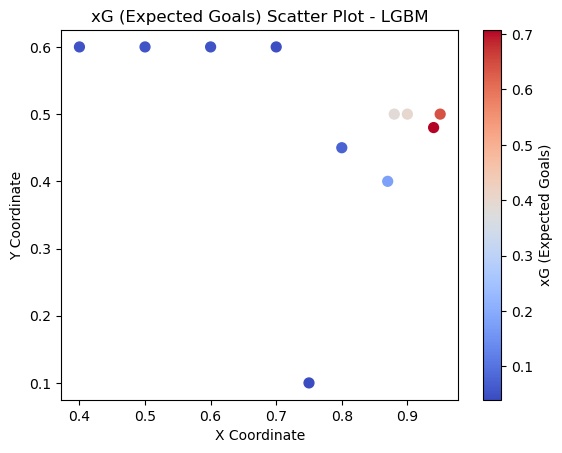

In [617]:
# Create a scatter plot showing Messi's xG values (leading scenario) using the LightGBM model
plt.scatter(combined_messi_xG_values_lgb['X'], combined_messi_xG_values_lgb['Y'], c=combined_messi_xG_values_lgb['xG_leading'], cmap='coolwarm', s=50)
plt.colorbar(label='xG (Expected Goals)')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('xG (Expected Goals) Scatter Plot - LGBM')
plt.show()

In [618]:
#AdaBoost

/Users/sp/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoost model Prediction


/Users/sp/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/sp/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/sp/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/sp/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  war

Best parameters: {'learning_rate': 0.5, 'n_estimators': 500}


/Users/sp/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Model Evaluation - AdaBoost
Accuracy: 0.85
Precision: 0.33
Recall: 0.44
ROC AUC: 0.77
Mean Squared Error: 0.15
F1 Score: 0.37
Log Loss value: 0.68
Confusion Matrix:
 [[41249  4905]
 [ 3034  2372]]
Brier Score: 0.24

Hyperparameter Tuning Model Evaluation - AdaBoost
Accuracy: 0.88
Precision: 0.41
Recall: 0.34
ROC AUC: 0.78
Mean Squared Error: 0.12
F1 Score: 0.37
Log Loss value: 0.69
Confusion Matrix:
 [[43499  2655]
 [ 3588  1818]]
Brier Score: 0.25


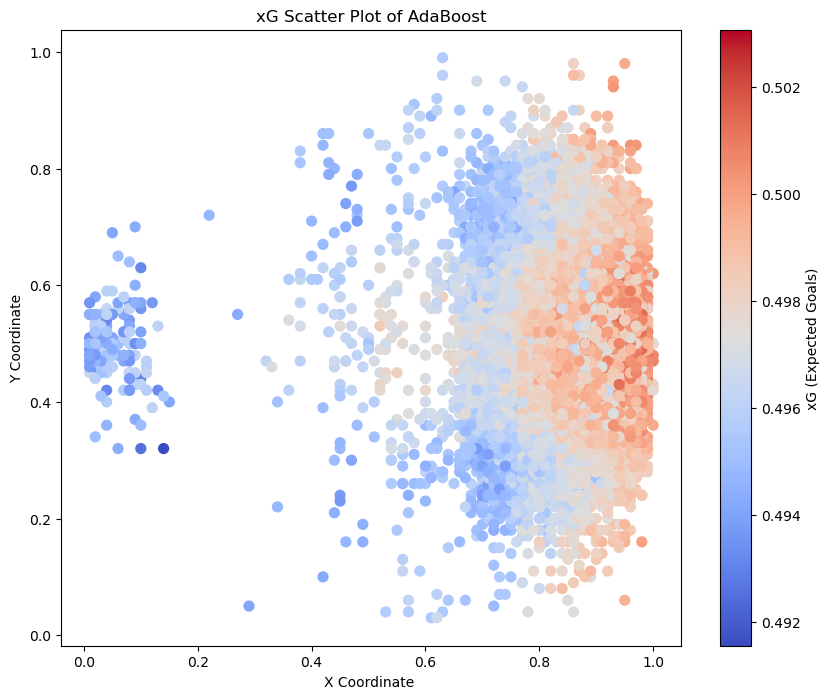

In [619]:
# Train and evaluate the AdaBoost model

# Initialize the AdaBoost model
adaboost_model = AdaBoostClassifier(random_state=42)

# Train the model and make predictions on the test set
y_pred, y_pred_proba = train_and_predict(adaboost_model, X_train_scaled_resampled, y_train_resampled, X_test_scaled, X_data_scaled, 0)

print("AdaBoost model Prediction")

# Define hyperparameter grid for tuning the AdaBoost model
param_grid = {
        'n_estimators': [50, 100, 200, 300, 500],
        'learning_rate': [0.01, 0.1, 0.2, 0.3, 0.5],
    }

# Perform hyperparameter tuning using the hyperparameter_tuning function
best_parameters = hyperparameter_tuning(AdaBoostClassifier(random_state=42),param_grid, X_train_scaled_resampled,y_train_resampled)

# Train the final AdaBoost model with the best hyperparameters
final_adaboost_model = AdaBoostClassifier(**best_parameters, random_state=42)
final_adaboost_model,y_pred_hyper, y_pred_proba_hyper, xg_data = train_and_predict(final_adaboost_model, X_train_scaled_resampled, y_train_resampled, X_test_scaled, X_data_scaled, 1)

# Store the xG predictions for the AdaBoost model in the test set and entire dataset
entire_data['xG_ADAB'] = xg_data
X_test['xG_ADAB'] = y_pred_proba_hyper

# Evaluate and plot the performance of the AdaBoost model
evaluate_model_and_plot(y_test, y_pred, y_pred_proba, y_pred_hyper, y_pred_proba_hyper, 'AdaBoost')

In [620]:
a_boost_model = final_adaboost_model

/var/folders/d8/qbh4kpvx1070jvh0n_2l3jt40000gn/T/ipykernel_11706/2726130034.py:81: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  scenario_xG_data = pd.concat([scenario_xG_data, new_data], ignore_index=True)
/var/folders/d8/qbh4kpvx1070jvh0n_2l3jt40000gn/T/ipykernel_11706/2726130034.py:81: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  scenario_xG_data = pd.concat([scenario_xG_data, new_data], ignore_index=True)
/var/folders/d8/qbh4kpvx1070jvh0n_2l3jt40000gn/T/ipykernel_11706/2726130034.py:81: Fut

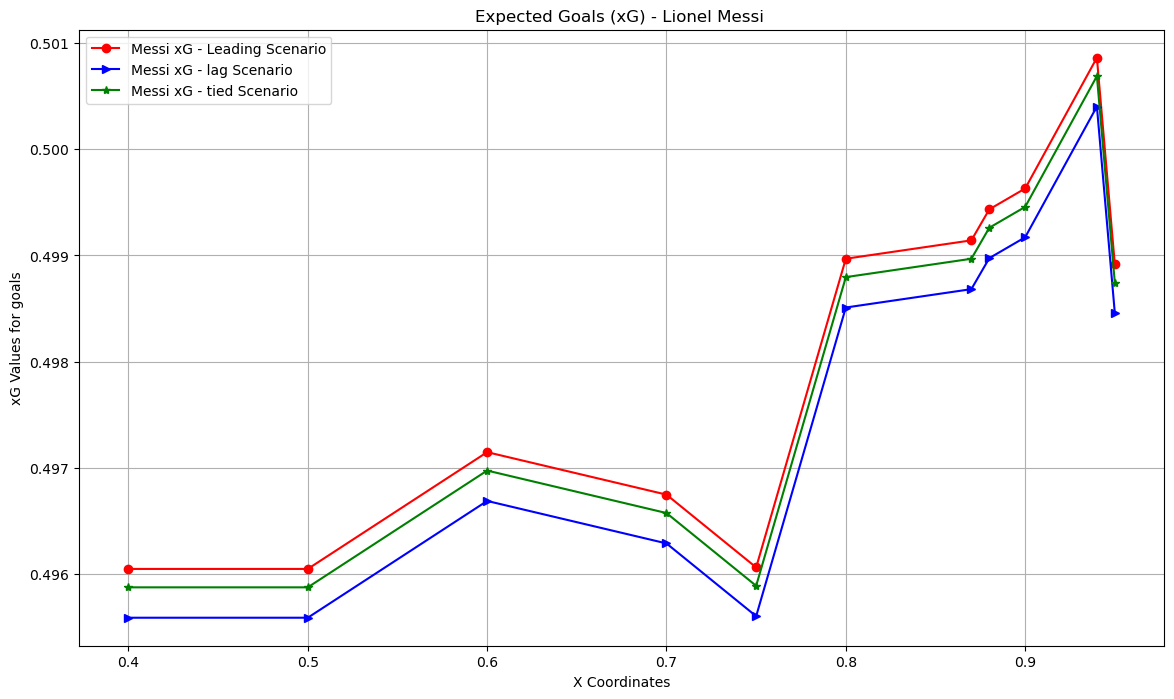

In [621]:
# Calculate xG for Lionel Messi in different game scenarios using the AdaBoost model
aboost_xG_data_messi = calculate_xG_for_scenarios(a_boost_model,player_name_messi, base_params)

# Combine Messi's xG values across different game scenarios for comparison
combined_messi_xG_values_aboost = combine_messi_xG_values(aboost_xG_data_messi)

# Sort the combined xG values for better plotting
combined_messi_xG_values_aboost.sort_values(by=["X", "Y"], inplace=True)

# Plot Messi's xG values for leading, lagging, and tied scenarios using the AdaBoost model
plt.figure(figsize=(14, 8))
plt.plot(combined_messi_xG_values_aboost['X'], combined_messi_xG_values_aboost['xG_leading'], label='Messi xG - Leading Scenario', color='red', marker='o')
plt.plot(combined_messi_xG_values_aboost['X'], combined_messi_xG_values_aboost['xG_lagging'], label='Messi xG - lag Scenario', color='blue', marker='>')
plt.plot(combined_messi_xG_values_aboost['X'], combined_messi_xG_values_aboost['xG_tied'], label='Messi xG - tied Scenario', color='green', marker='*')

# plt.plot(goal_df['X_coord'], goal_df['xG_calc_xgb'], label='xg_xgb', color='green', marker='s')

# Customizing the plot
plt.title('Expected Goals (xG) - Lionel Messi ')
plt.xlabel('X Coordinates')
plt.ylabel('xG Values for goals')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

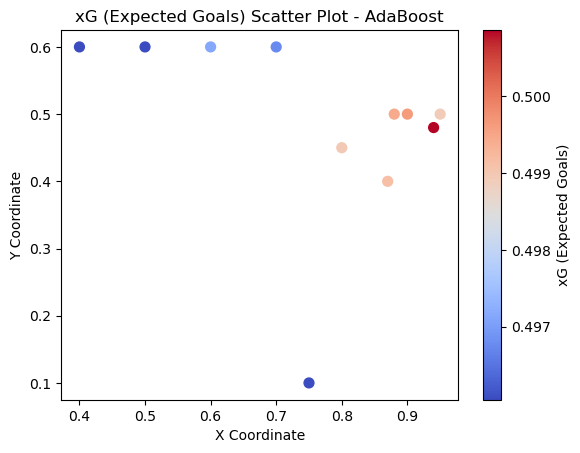

In [622]:
# Create a scatter plot showing Messi's xG values (leading scenario) using the AdaBoost model
plt.scatter(combined_messi_xG_values_aboost['X'], combined_messi_xG_values_aboost['Y'], c=combined_messi_xG_values_aboost['xG_leading'], cmap='coolwarm', s=50)
plt.colorbar(label='xG (Expected Goals)')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('xG (Expected Goals) Scatter Plot - AdaBoost')
plt.show()

CatBoost model Prediction
Best parameters: {'depth': 8, 'iterations': 100, 'learning_rate': 0.2}
Model Evaluation - CatBoost
Accuracy: 0.91
Precision: 0.65
Recall: 0.21
ROC AUC: 0.81
Mean Squared Error: 0.09
F1 Score: 0.31
Log Loss value: 0.27
Confusion Matrix:
 [[45566   588]
 [ 4294  1112]]
Brier Score: 0.08

Hyperparameter Tuning Model Evaluation - CatBoost
Accuracy: 0.91
Precision: 0.65
Recall: 0.21
ROC AUC: 0.81
Mean Squared Error: 0.09
F1 Score: 0.32
Log Loss value: 0.27
Confusion Matrix:
 [[45558   596]
 [ 4281  1125]]
Brier Score: 0.08


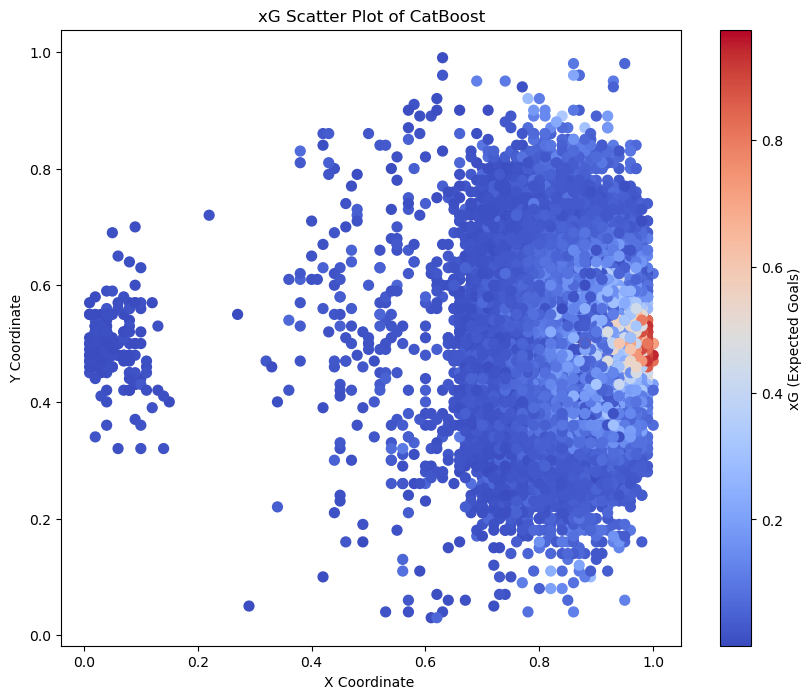

In [623]:
# Train and evaluate the CatBoost model

# Initialize the CatBoost model
catboost_model = CatBoostClassifier(random_state=42, verbose=0)

# Train the model and make predictions on the test set
y_pred, y_pred_proba = train_and_predict(catboost_model, X_train_scaled_resampled, y_train_resampled, X_test_scaled, X_data_scaled, 0)

print("CatBoost model Prediction")

# Define hyperparameter grid for tuning the CatBoost model
param_grid = {
       'iterations': [100, 300, 500],
        'learning_rate': [0.01, 0.1, 0.2],
        'depth': [6, 8, 10]
    }

# Perform hyperparameter tuning using the hyperparameter_tuning function
best_parameters = hyperparameter_tuning(CatBoostClassifier(random_state=42, verbose=0),param_grid, X_train_scaled_resampled,y_train_resampled)

# Train the final CatBoost model with the best hyperparameters
final_catboost_model = CatBoostClassifier(**best_parameters, random_state=42, verbose=0)
final_catboost_model,y_pred_hyper, y_pred_proba_hyper, xg_data = train_and_predict(final_catboost_model, X_train_scaled_resampled, y_train_resampled, X_test_scaled, X_data_scaled, 1)

# Store the xG predictions for the CatBoost model in the test set and entire dataset
entire_data['xG_CAT'] = xg_data
X_test['xG_CAT'] = y_pred_proba_hyper

# Evaluate and plot the performance of the CatBoost model
evaluate_model_and_plot(y_test, y_pred, y_pred_proba, y_pred_hyper, y_pred_proba_hyper, 'CatBoost')

In [624]:
cat_boost_model = final_catboost_model

/var/folders/d8/qbh4kpvx1070jvh0n_2l3jt40000gn/T/ipykernel_11706/2726130034.py:81: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  scenario_xG_data = pd.concat([scenario_xG_data, new_data], ignore_index=True)
/var/folders/d8/qbh4kpvx1070jvh0n_2l3jt40000gn/T/ipykernel_11706/2726130034.py:81: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  scenario_xG_data = pd.concat([scenario_xG_data, new_data], ignore_index=True)
/var/folders/d8/qbh4kpvx1070jvh0n_2l3jt40000gn/T/ipykernel_11706/2726130034.py:81: Fut

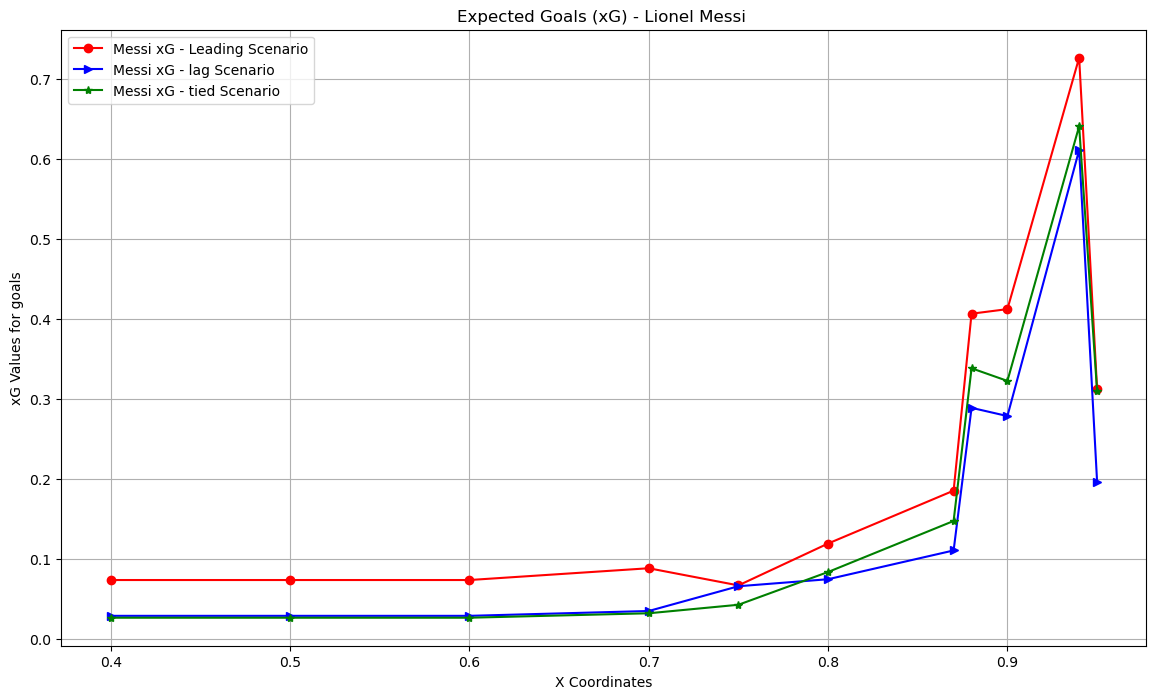

In [625]:
# Calculate xG for Lionel Messi in different game scenarios using the CatBoost model
catboost_xG_data_messi = calculate_xG_for_scenarios(cat_boost_model,player_name_messi, base_params)

# Combine Messi's xG values across different game scenarios for comparison
combined_messi_xG_values_catboost = combine_messi_xG_values(catboost_xG_data_messi)

# Sort the combined xG values for better plotting
combined_messi_xG_values_catboost.sort_values(by=["X", "Y"], inplace=True)

# Plot Messi's xG values for leading, lagging, and tied scenarios using the CatBoost model
plt.figure(figsize=(14, 8))
plt.plot(combined_messi_xG_values_catboost['X'], combined_messi_xG_values_catboost['xG_leading'], label='Messi xG - Leading Scenario', color='red', marker='o')
plt.plot(combined_messi_xG_values_catboost['X'], combined_messi_xG_values_catboost['xG_lagging'], label='Messi xG - lag Scenario', color='blue', marker='>')
plt.plot(combined_messi_xG_values_catboost['X'], combined_messi_xG_values_catboost['xG_tied'], label='Messi xG - tied Scenario', color='green', marker='*')

# plt.plot(goal_df['X_coord'], goal_df['xG_calc_xgb'], label='xg_xgb', color='green', marker='s')

# Customizing the plot
plt.title('Expected Goals (xG) - Lionel Messi ')
plt.xlabel('X Coordinates')
plt.ylabel('xG Values for goals')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

In [626]:
combined_messi_xG_values_catboost

X     Y  Y_angle  overall_striker  xG_leading  xG_lagging   xG_tied
0   0.40  0.60     0.80        93.549035    0.073200    0.028385  0.026020
1   0.50  0.60     0.80        93.549035    0.073200    0.028385  0.026020
2   0.60  0.60     0.80        93.549035    0.073200    0.028385  0.026020
3   0.70  0.60     0.80        93.549035    0.087942    0.034437  0.031584
4   0.75  0.10     0.20        93.549035    0.066465    0.065421  0.042233
5   0.80  0.45     0.90        93.549035    0.118881    0.074205  0.083241
6   0.87  0.40     0.80        93.549035    0.185066    0.110204  0.147101
7   0.88  0.50     1.00        93.549035    0.406504    0.288719  0.338205
8   0.90  0.50     1.00        93.549035    0.412240    0.278393  0.322402
9   0.94  0.48     0.96        93.549035    0.726875    0.611398  0.641178
10  0.95  0.50     1.00        93.549035    0.312100    0.196494  0.309919

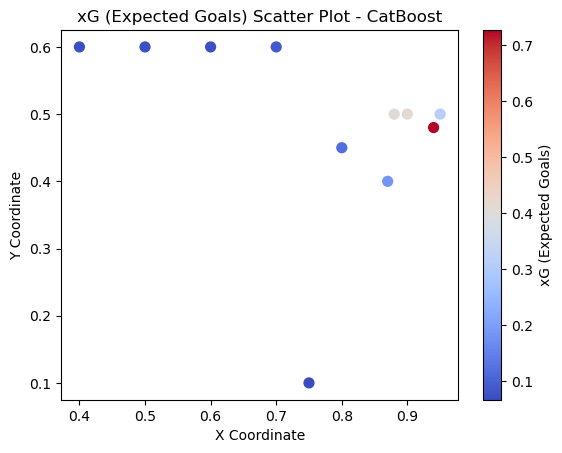

In [627]:
# Create a scatter plot showing Messi's xG values (leading scenario) using the CatBoost model
plt.scatter(combined_messi_xG_values_catboost['X'], combined_messi_xG_values_catboost['Y'], c=combined_messi_xG_values_catboost['xG_leading'], cmap='coolwarm', s=50)
plt.colorbar(label='xG (Expected Goals)')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('xG (Expected Goals) Scatter Plot - CatBoost')
plt.show()

In [628]:
#LSTM

In [875]:
# Reshape data for LSTM input to match the required input format (samples, time steps, features)
X_train_reshaped = X_train_scaled.reshape(X_train_scaled.shape[0], 1, X_train_scaled.shape[1])
X_test_reshaped = X_test_scaled.reshape(X_test_scaled.shape[0], 1, X_test_scaled.shape[1])

# Build an LSTM model with a single LSTM layer and a Dense output layer
lstm_model = Sequential()
lstm_model.add(LSTM(64, input_shape=(1, X_train_scaled.shape[1]), activation='relu'))
lstm_model.add(Dense(1, activation='sigmoid'))

# Compile the LSTM model using Adam optimizer, binary cross-entropy loss, and accuracy metric
lstm_model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.001), metrics=['accuracy'])

# Train the LSTM model on the training data for 10 epochs with batch size of 32
lstm_model.fit(X_train_reshaped, y_train, epochs=10, batch_size=32, validation_data=(X_test_reshaped, y_test))

# Predict probabilities for the test data using the trained LSTM model
y_pred_proba = lstm_model.predict(X_test_reshaped)

# Add predicted xG values to the test data DataFrame
X_test['xG_LSTM'] = y_pred_proba

# Convert the predicted probabilities into binary predictions using a threshold of 0.5
y_pred = (y_pred_proba > 0.5).astype(int)

Epoch 1/10
6445/6445 [==============================] - 4s 523us/step - loss: 0.3065 - accuracy: 0.9012 - val_loss: 0.2858 - val_accuracy: 0.9021
Epoch 2/10
6445/6445 [==============================] - 3s 503us/step - loss: 0.2825 - accuracy: 0.9022 - val_loss: 0.2777 - val_accuracy: 0.9033
Epoch 3/10
6445/6445 [==============================] - 3s 502us/step - loss: 0.2776 - accuracy: 0.9027 - val_loss: 0.2769 - val_accuracy: 0.9042
Epoch 4/10
6445/6445 [==============================] - 3s 537us/step - loss: 0.2763 - accuracy: 0.9029 - val_loss: 0.2734 - val_accuracy: 0.9033
Epoch 5/10
6445/6445 [==============================] - 4s 574us/step - loss: 0.2760 - accuracy: 0.9032 - val_loss: 0.2733 - val_accuracy: 0.9040
Epoch 6/10
6445/6445 [==============================] - 3s 512us/step - loss: 0.2755 - accuracy: 0.9032 - val_loss: 0.2813 - val_accuracy: 0.9021
Epoch 7/10
6445/6445 [==============================] - 3s 515us/step - loss: 0.2752 - accuracy: 0.9033 - val_loss: 0.2741 -

In [876]:
print("LSTM - Long Short Term Memory Model Evaluation")

# Calculate and print various evaluation metrics including accuracy, precision, recall, and ROC AUC
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
mse = mean_squared_error(y_test, y_pred_proba)
f1 = f1_score(y_test, y_pred)
log_loss_val = log_loss(y_test, y_pred_proba)
conf_matrix = confusion_matrix(y_test, y_pred)
r2 = r2_score(y_test, y_pred_proba)
brier_score = brier_score_loss(y_test, y_pred_proba)

# Print the calculated evaluation metrics to assess the LSTM model's performance
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"ROC AUC: {roc_auc:.2f}")
print(f"Mean Squared Error: {mse:.2f}")
print(f"F1 Score: {f1}")
print(f"Log Loss: {log_loss_val:.2f}")
print("Confusion Matrix:\n", conf_matrix)
print(f"R-squared: {r2:.2f}")
print(f"Brier Score: {brier_score:.2f}")

# Print classification report
print("Classification Report:\n", classification_report(y_test, y_pred))

LSTM - Long Short Term Memory Model Evaluation
Accuracy: 0.90
Precision: 0.74
Recall: 0.14
ROC AUC: 0.80
Mean Squared Error: 0.08
F1 Score: 0.23180256169946892
Log Loss: 0.27
Confusion Matrix:
 [[45900   254]
 [ 4664   742]]
R-squared: 0.17
Brier Score: 0.08
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.99      0.95     46154
           1       0.74      0.14      0.23      5406

    accuracy                           0.90     51560
   macro avg       0.83      0.57      0.59     51560
weighted avg       0.89      0.90      0.87     51560



1/1 [==============================] - 0s 6ms/step


/var/folders/d8/qbh4kpvx1070jvh0n_2l3jt40000gn/T/ipykernel_11706/2726130034.py:81: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  scenario_xG_data = pd.concat([scenario_xG_data, new_data], ignore_index=True)


1/1 [==============================] - 0s 12ms/step


/var/folders/d8/qbh4kpvx1070jvh0n_2l3jt40000gn/T/ipykernel_11706/2726130034.py:81: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  scenario_xG_data = pd.concat([scenario_xG_data, new_data], ignore_index=True)


1/1 [==============================] - 0s 7ms/step


/var/folders/d8/qbh4kpvx1070jvh0n_2l3jt40000gn/T/ipykernel_11706/2726130034.py:81: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  scenario_xG_data = pd.concat([scenario_xG_data, new_data], ignore_index=True)


1/1 [==============================] - 0s 7ms/step


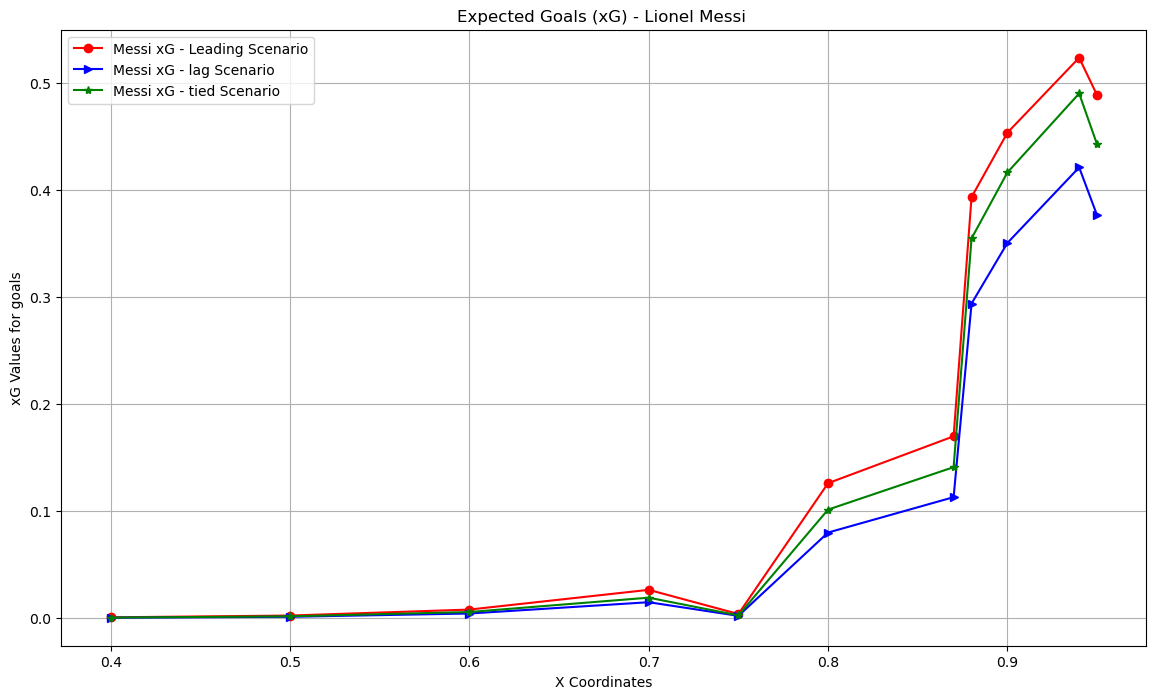

In [631]:
# Calculate xG values for Lionel Messi in different game scenarios using the trained LSTM model
lstm_xG_data_messi = calculate_xG_for_scenarios(lstm_model,player_name_messi, base_params)

# Combine Messi's xG values across different game scenarios for better comparison
combined_messi_xG_values_lstm = combine_messi_xG_values(lstm_xG_data_messi)

# Sort combined xG data by X and Y coordinates for better plotting
combined_messi_xG_values_lstm.sort_values(by=["X", "Y"], inplace=True)

# Plot Messi's xG values in leading, lagging, and tied game scenarios using the LSTM model
plt.figure(figsize=(14, 8))
plt.plot(combined_messi_xG_values_lstm['X'], combined_messi_xG_values_lstm['xG_leading'], label='Messi xG - Leading Scenario', color='red', marker='o')
plt.plot(combined_messi_xG_values_lstm['X'], combined_messi_xG_values_lstm['xG_lagging'], label='Messi xG - lag Scenario', color='blue', marker='>')
plt.plot(combined_messi_xG_values_lstm['X'], combined_messi_xG_values_lstm['xG_tied'], label='Messi xG - tied Scenario', color='green', marker='*')

# plt.plot(goal_df['X_coord'], goal_df['xG_calc_xgb'], label='xg_xgb', color='green', marker='s')

# Customizing the plot
plt.title('Expected Goals (xG) - Lionel Messi ')
plt.xlabel('X Coordinates')
plt.ylabel('xG Values for goals')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

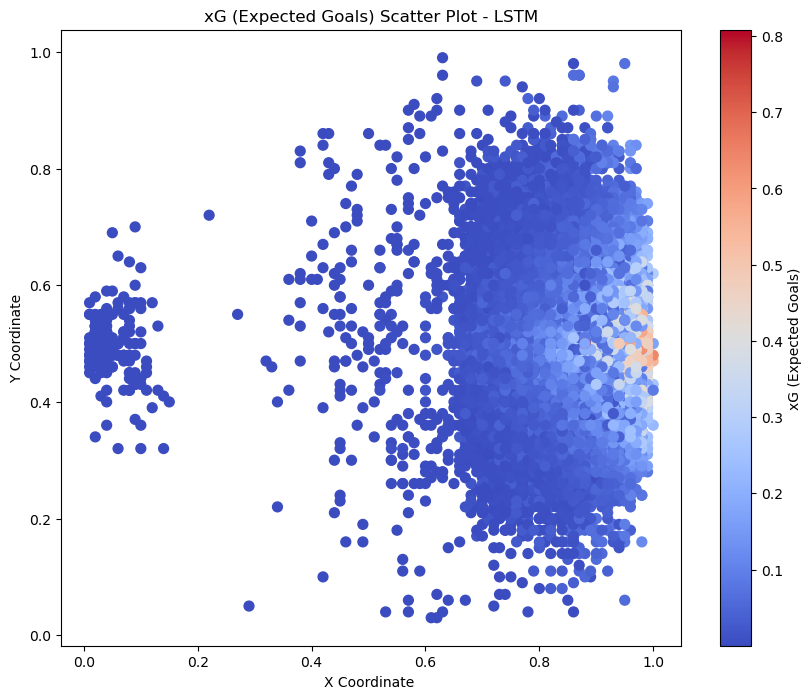

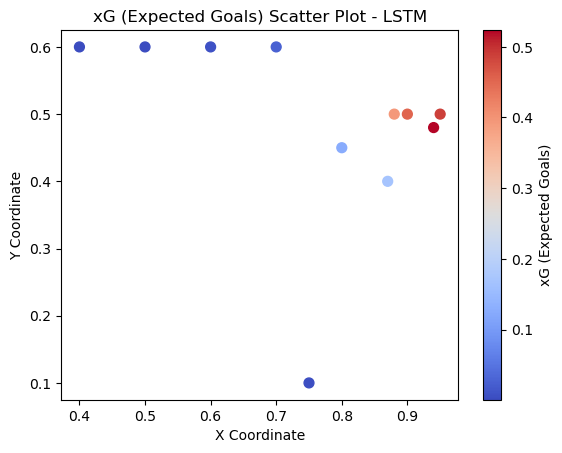

In [632]:
# Scatter plot displaying Messi's xG values with respect to shot location for the LSTM model
plt.figure(figsize=(10, 8))
# plt.scatter(data['X_coord'], data['Y_coord_angle'], c=data['xG_calc_LR'], cmap='coolwarm', s=50)
plt.scatter(X_test['X'], X_test['Y'], c=X_test['xG_LSTM'], cmap='coolwarm', s=50)
plt.colorbar(label='xG (Expected Goals)')
plt.xlabel('X Coordinate ')
plt.ylabel('Y Coordinate')
plt.title('xG (Expected Goals) Scatter Plot - LSTM')
plt.show()

# Scatter plot displaying xG values with respect to shot coordinates in the leading scenario for Messi using LSTM
plt.scatter(combined_messi_xG_values_lstm['X'], combined_messi_xG_values_lstm['Y'], c=combined_messi_xG_values_lstm['xG_leading'], cmap='coolwarm', s=50)
plt.colorbar(label='xG (Expected Goals)')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('xG (Expected Goals) Scatter Plot - LSTM')
plt.show()

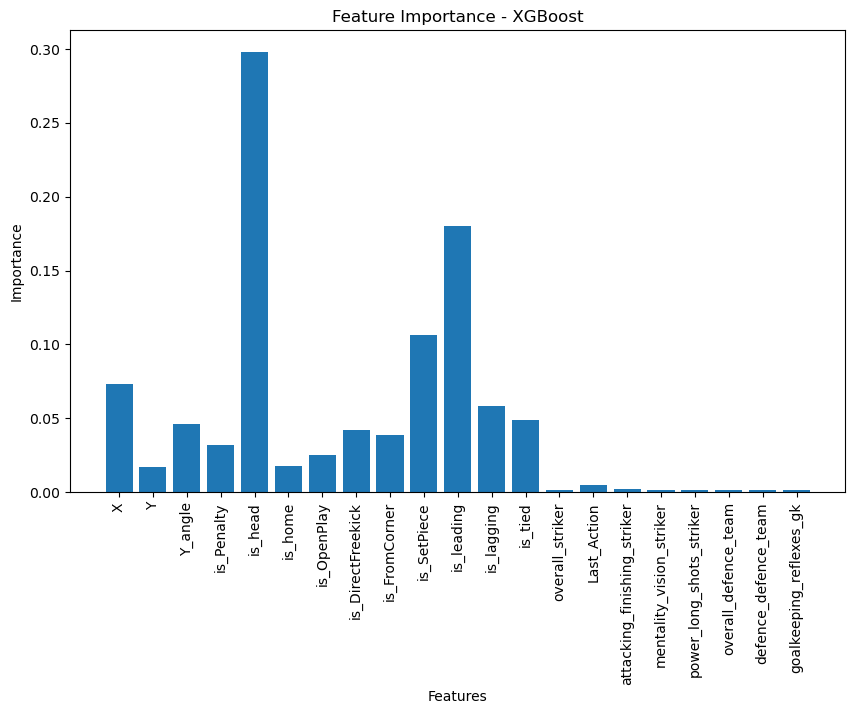

X: 0.07324370741844177
Y: 0.01692703180015087
Y_angle: 0.04584534838795662
is_Penalty: 0.031781915575265884
is_head: 0.29780691862106323
is_home: 0.017736373469233513
is_OpenPlay: 0.02541680634021759
is_DirectFreekick: 0.04228353872895241
is_FromCorner: 0.03882783278822899
is_SetPiece: 0.10630140453577042
is_leading: 0.1804732382297516
is_lagging: 0.0585472546517849
is_tied: 0.04921052232384682
overall_striker: 0.0012652934528887272
Last_Action: 0.004905616398900747
attacking_finishing_striker: 0.0018718625651672482
mentality_vision_striker: 0.001493298914283514
power_long_shots_striker: 0.0017427963903173804
overall_defence_team: 0.0014732414856553078
defence_defence_team: 0.0015322534600272775
goalkeeping_reflexes_gk: 0.0013137578498572111


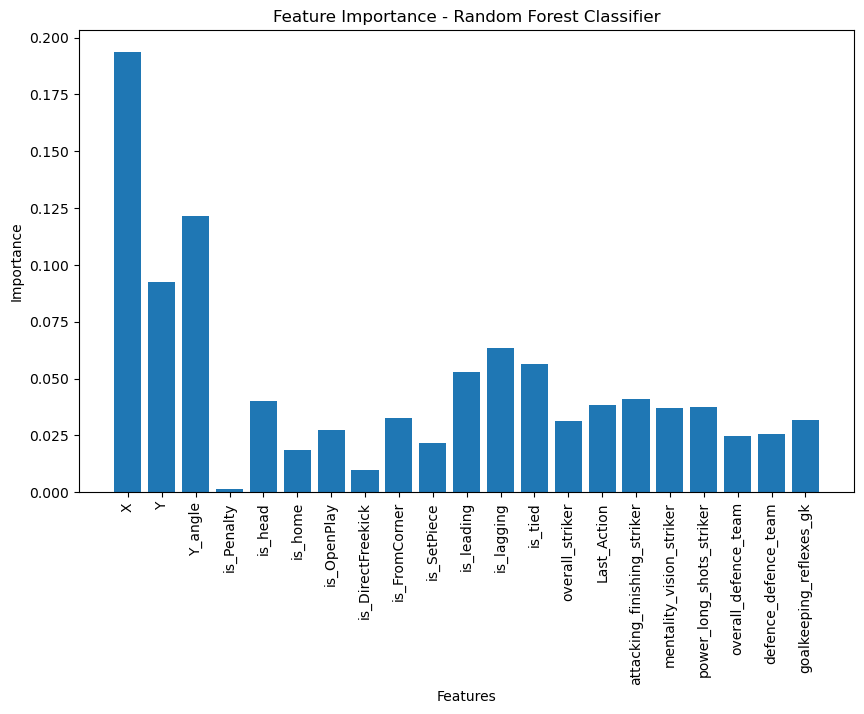

X: 0.19357693106573864
Y: 0.09234607168371464
Y_angle: 0.12155833023190851
is_Penalty: 0.0014352071091291588
is_head: 0.040190378557834625
is_home: 0.01841920217331384
is_OpenPlay: 0.02733985331313668
is_DirectFreekick: 0.009952403066869972
is_FromCorner: 0.03264522560131474
is_SetPiece: 0.021738225066357468
is_leading: 0.05290971752867719
is_lagging: 0.06331251419098334
is_tied: 0.05656164417075282
overall_striker: 0.031352444898562794
Last_Action: 0.03843146658500205
attacking_finishing_striker: 0.041160989497442284
mentality_vision_striker: 0.036922652555135764
power_long_shots_striker: 0.03745625987674537
overall_defence_team: 0.024935623344987296
defence_defence_team: 0.025828368076974036
goalkeeping_reflexes_gk: 0.031926491405418665


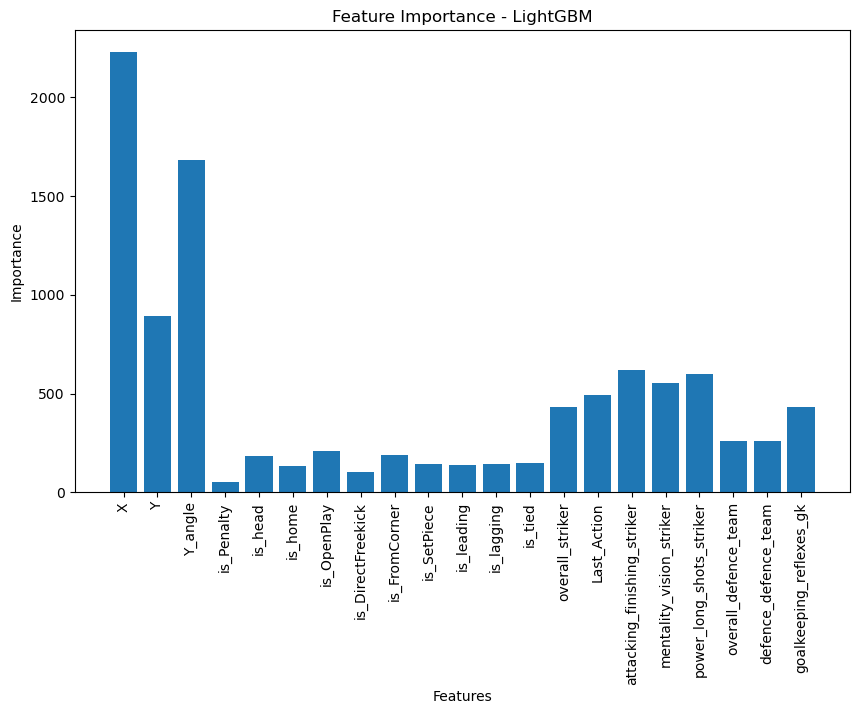

X: 2229
Y: 893
Y_angle: 1683
is_Penalty: 54
is_head: 184
is_home: 134
is_OpenPlay: 211
is_DirectFreekick: 100
is_FromCorner: 190
is_SetPiece: 141
is_leading: 138
is_lagging: 142
is_tied: 150
overall_striker: 433
Last_Action: 492
attacking_finishing_striker: 621
mentality_vision_striker: 552
power_long_shots_striker: 599
overall_defence_team: 262
defence_defence_team: 260
goalkeeping_reflexes_gk: 432


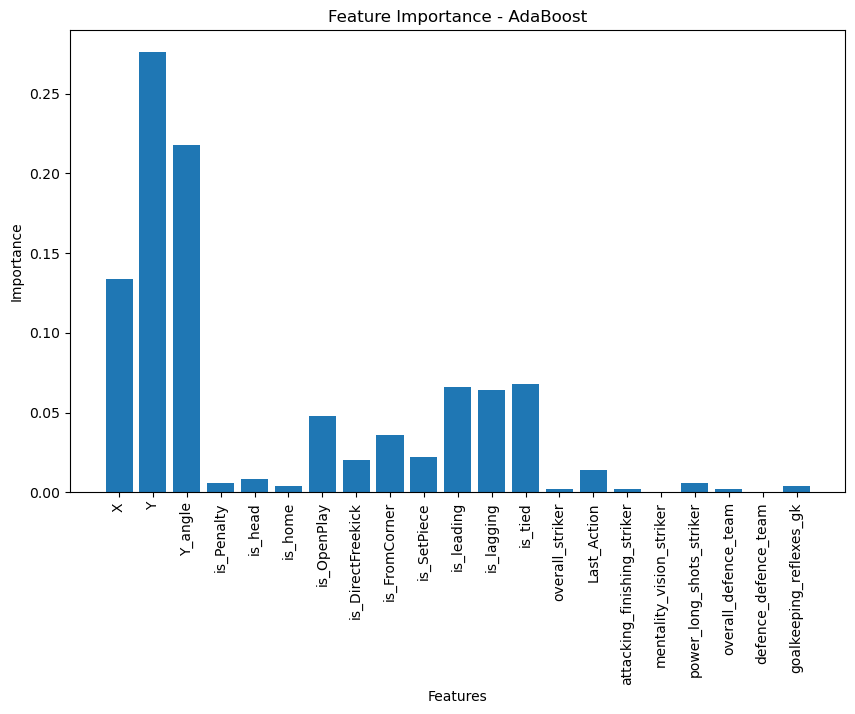

X: 0.134
Y: 0.276
Y_angle: 0.218
is_Penalty: 0.006
is_head: 0.008
is_home: 0.004
is_OpenPlay: 0.048
is_DirectFreekick: 0.02
is_FromCorner: 0.036
is_SetPiece: 0.022
is_leading: 0.066
is_lagging: 0.064
is_tied: 0.068
overall_striker: 0.002
Last_Action: 0.014
attacking_finishing_striker: 0.002
mentality_vision_striker: 0.0
power_long_shots_striker: 0.006
overall_defence_team: 0.002
defence_defence_team: 0.0
goalkeeping_reflexes_gk: 0.004


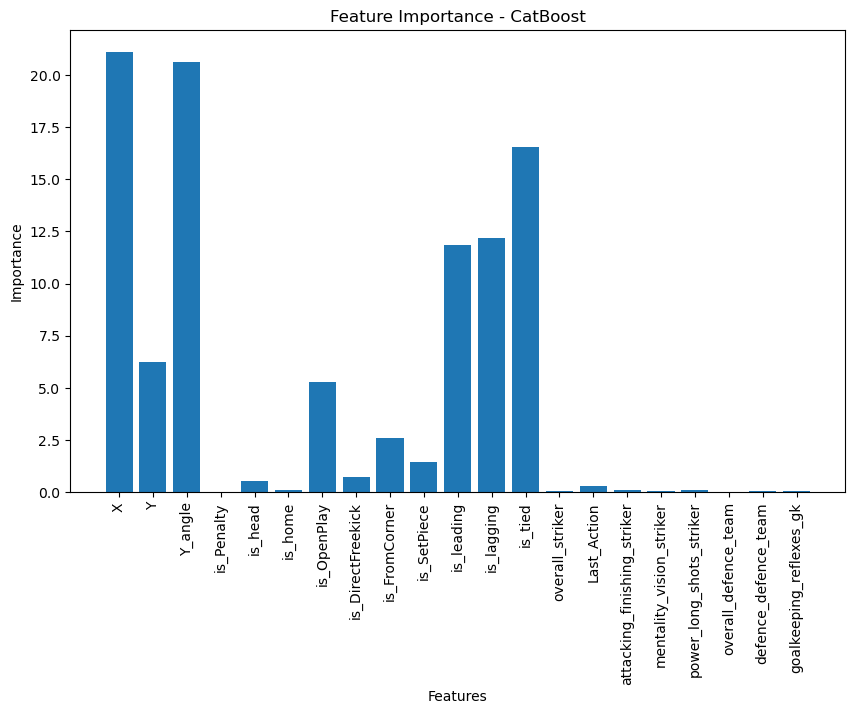

X: 21.090688747273102
Y: 6.234852076460496
Y_angle: 20.613479146500293
is_Penalty: 0.0023857626847833074
is_head: 0.5452062576335259
is_home: 0.11153164974003794
is_OpenPlay: 5.284924331537588
is_DirectFreekick: 0.7203879612779333
is_FromCorner: 2.5985937826792043
is_SetPiece: 1.4479900667022798
is_leading: 11.85379140410697
is_lagging: 12.204783773995365
is_tied: 16.566745000803785
overall_striker: 0.06471956473753204
Last_Action: 0.2997359376682716
attacking_finishing_striker: 0.10076954650859475
mentality_vision_striker: 0.03941960223457536
power_long_shots_striker: 0.08794893352631906
overall_defence_team: 0.029255066710584452
defence_defence_team: 0.049413045956331156
goalkeeping_reflexes_gk: 0.05337834126243195


In [866]:
# Function to calculate and plot feature importance for models that have feature_importances_ or coef_ attributes
def calculate_feature_importance(model, model_name):
    """
    Calculate and plot feature importance for a given model.

    Args:
        model: The trained model to analyze.
        model_name: Name of the model for display in the plot title.
    """
    # Access the global features DataFrame
    global features

    feature_names = features.columns.tolist()

    # Check if the model has feature_importances_ attribute (tree-based models)
    if hasattr(model, 'feature_importances_'):
        feature_importances = model.feature_importances_

    # Check if the model has coef_ attribute (linear models like Logistic Regression)
    elif hasattr(model, 'coef_'):
        feature_importances = model.coef_[0]
    else:
        print(f"The model {model_name} does not have feature_importances_ or coef_ attributes.")
        return

    # Plot the feature importances
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(feature_importances)), feature_importances)
    plt.xticks(range(len(feature_importances)), feature_names, rotation='vertical')
    plt.xlabel('Features')
    plt.ylabel('Importance')
    plt.title(f'Feature Importance - {model_name}')
    plt.show()

    # Print feature importances
    for feature, importance in zip(feature_names, feature_importances):
        print(f"{feature}: {importance}")

# Assuming features DataFrame is already defined and the models are trained
# Example usage for different models:

# XGBoost model
calculate_feature_importance(final_xgboost_model, 'XGBoost')

# Random Forest Classifier model
calculate_feature_importance(final_rf_model, 'Random Forest Classifier')

# LightGBM model
calculate_feature_importance(final_lgb_model, 'LightGBM')

# AdaBoost model
calculate_feature_importance(final_adaboost_model, 'AdaBoost')

# CatBoost model
calculate_feature_importance(final_catboost_model, 'CatBoost')


PermutationExplainer explainer: 51561it [10:42, 79.11it/s]                      


Selected Instance Features:
X                               0.750000
Y                               0.470000
Y_angle                         0.940000
is_Penalty                      0.000000
is_head                         0.000000
is_home                         1.000000
is_OpenPlay                     0.000000
is_DirectFreekick               1.000000
is_FromCorner                   0.000000
is_SetPiece                     0.000000
is_leading                      0.000000
is_lagging                      0.000000
is_tied                         1.000000
overall_striker                75.000000
Last_Action                     8.000000
attacking_finishing_striker    62.000000
mentality_vision_striker       75.000000
power_long_shots_striker       75.000000
overall_defence_team           74.000000
defence_defence_team           74.000000
goalkeeping_reflexes_gk        83.000000
xG_XG                           0.088143
xG_LR                           0.129658
xG_RF                        

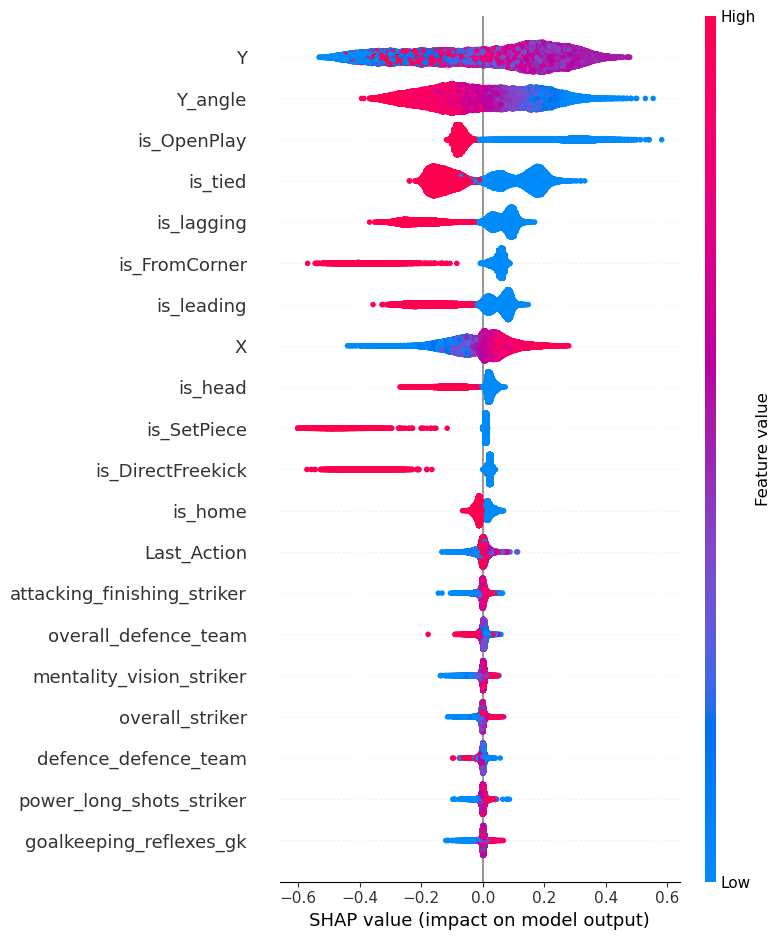

In [868]:
# Feature Importance of ANN Model using SHAP

# Initialize SHAP explainer for the Keras ANN model using the training data
ann_shap_explainer = shap.Explainer(ann_model, X_train_scaled)

# Calculate SHAP values for the test dataset
shap_values_ann = ann_shap_explainer(X_test_scaled)

# Choose a specific instance to analyze feature importance
selected_instance_index = 0  # Specify the instance index to inspect
selected_instance_features = X_test.iloc[selected_instance_index]

# Print the feature values of the selected instance for reference
print("Selected Instance Features:")
print(selected_instance_features)

# Print the corresponding SHAP values for the selected instance
selected_instance_shap_values = shap_values_ann[selected_instance_index]
print("SHAP Values for Selected Instance:")
print(selected_instance_shap_values)

# Create a SHAP summary plot for feature importance based on the entire test dataset
shap.summary_plot(shap_values_ann, X_test_scaled, feature_names=features.columns)

# Show the plot
plt.show()

In [634]:
# Display the shape of the scaled features data
X_data_scaled.shape

(257800, 21)

In [635]:
#ENSEMBLE_MODEL

In [636]:
# Voting classifier with two estimators: LightGBM and CatBoost models
voting_clf = VotingClassifier(
    estimators=[
        ('lgb', final_lgb_model),
        ('cat', final_catboost_model)
    ],
    voting='soft'  #Soft voting uses the predicted probabilities for combining predictions
)

In [637]:
# Fit the voting classifier on the resampled training data
voting_clf.fit(X_train_scaled_resampled, y_train_resampled)

# Predict probabilities and labels for the test set using the voting classifier
y_pred_proba = voting_clf.predict_proba(X_test_scaled)[:, 1]  # Get probability of positive class
y_pred = voting_clf.predict(X_test_scaled)   # Get final class prediction

[LightGBM] [Info] Number of positive: 184616, number of negative: 180591
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003499 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1174
[LightGBM] [Info] Number of data points in the train set: 365207, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505511 -> initscore=0.022043
[LightGBM] [Info] Start training from score 0.022043


In [638]:
print("Voting Classifier Model Evaluation")

# Accuracy evaluation
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
precision = precision_score(y_test, y_pred)
print(f"Precision: {precision:.2f}")
recall = recall_score(y_test, y_pred)
print(f"Recall: {recall:.2f}")
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC AUC: {roc_auc:.2f}")
mse = mean_squared_error(y_test, y_pred_proba)
print(f"Mean Squared Error: {mse:.2f}")
f1 = f1_score(y_test, y_pred)
print(f"F1 Score: {f1:.2f}")
log_loss_val = log_loss(y_test, y_pred_proba)
print(f"Log Loss value: {log_loss_val:.2f}")
conf_matrix = confusion_matrix(y_test, y_pred)
print(f"Confusion Matrix:\n{conf_matrix}")
brier_score = brier_score_loss(y_test, y_pred_proba)
print(f"Brier Score: {brier_score:.2f}")

Voting Classifier Model Evaluation
Accuracy: 0.91
Precision: 0.64
Recall: 0.21
ROC AUC: 0.81
Mean Squared Error: 0.08
F1 Score: 0.32
Log Loss value: 0.27
Confusion Matrix:
[[45508   646]
 [ 4248  1158]]
Brier Score: 0.08


In [639]:
# Another voting classifier combining CatBoost, XGBoost, and LightGBM models
voting_clf = VotingClassifier(
    estimators=[
        ('cat', final_catboost_model),
        ('xgb', final_xgboost_model),
        ('lgb', final_lgb_model)
    ],
    voting='soft' 
)

# Fit the new voting classifier
voting_clf.fit(X_train_scaled_resampled, y_train_resampled)

# Predict probabilities and labels for the test set
y_pred_proba = voting_clf.predict_proba(X_test_scaled)[:, 1]
y_pred = voting_clf.predict(X_test_scaled)

# Print model evaluation metrics for the new voting classifier
print("Voting Classifier Model Evaluation")
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
precision = precision_score(y_test, y_pred)
print(f"Precision: {precision:.2f}")
recall = recall_score(y_test, y_pred)
print(f"Recall: {recall:.2f}")
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC AUC: {roc_auc:.2f}")
mse = mean_squared_error(y_test, y_pred_proba)
print(f"Mean Squared Error: {mse:.2f}")
f1 = f1_score(y_test, y_pred)
print(f"F1 Score: {f1:.2f}")
log_loss_val = log_loss(y_test, y_pred_proba)
print(f"Log Loss value: {log_loss_val:.2f}")
conf_matrix = confusion_matrix(y_test, y_pred)
print(f"Confusion Matrix:\n{conf_matrix}")
brier_score = brier_score_loss(y_test, y_pred_proba)
print(f"Brier Score: {brier_score:.2f}")

[LightGBM] [Info] Number of positive: 184616, number of negative: 180591
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003125 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1174
[LightGBM] [Info] Number of data points in the train set: 365207, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505511 -> initscore=0.022043
[LightGBM] [Info] Start training from score 0.022043
Voting Classifier Model Evaluation
Accuracy: 0.90
Precision: 0.61
Recall: 0.24
ROC AUC: 0.81
Mean Squared Error: 0.08
F1 Score: 0.34
Log Loss value: 0.27
Confusion Matrix:
[[45337   817]
 [ 4134  1272]]
Brier Score: 0.08


In [640]:
#STACKING CLASSIFIER

In [906]:
# Define the estimators for the stacking classifier
estimators = [
    ('xgb', final_xgboost_model),
    ('lgb', final_lgb_model),
    ('cat', final_catboost_model)
    
]

# Define the meta-classifier (Logistic Regression) for stacking
meta_classifier = LogisticRegression()

# Stacking classifier combining XGBoost, LightGBM, and CatBoost with Logistic Regression as a meta-classifier
stacking_clf = StackingClassifier(
    estimators=estimators,
    final_estimator=meta_classifier,
    cv=3,
    stack_method='predict_proba'  # Use predict_proba for soft voting in meta-classifier
)

# Fit the stacking classifier on the training data on unsampled data
stacking_clf.fit(X_train_scaled, y_train)

# Predict probabilities using the stacking classifier for the test set
xG_values_stacking = stacking_clf.predict_proba(X_test_scaled)[:, 1]
xG_stacking_preds = (xG_values_stacking > 0.5).astype(int)


[LightGBM] [Info] Number of positive: 21624, number of negative: 184616
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005912 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 651
[LightGBM] [Info] Number of data points in the train set: 206240, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.104849 -> initscore=-2.144474
[LightGBM] [Info] Start training from score -2.144474
[LightGBM] [Info] Number of positive: 14416, number of negative: 123077
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003783 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 645
[LightGBM] [Info] Number of data points in the train set: 137493, number of used features: 21
[LightGBM] [Info

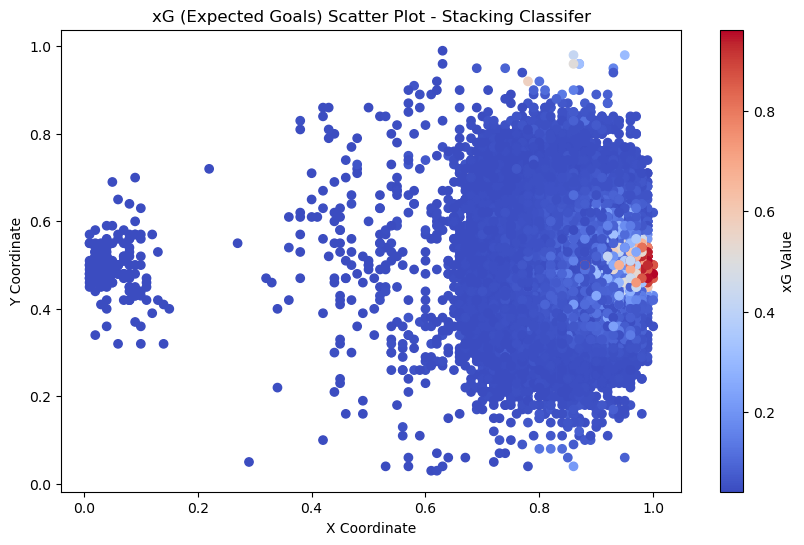

Stacking Model Accuracy: 0.91
Precision: 0.66
Recall: 0.21
ROC AUC: 0.8115651892518109
Mean Squared Error: 0.08
F1 Score: 0.31834785051980896
Log Loss value : 0.2711429440589507
Confusion Matrix:
 [[45575   579]
 [ 4273  1133]]
Brier Score : 0.07638700478037175


In [907]:
# Scatter plot displaying stacking xG values on the football pitch
plt.figure(figsize=(10, 6))
plt.scatter(X_test['X'], X_test['Y'], c=xG_values_stacking, cmap='coolwarm')
plt.colorbar(label='xG Value')
plt.title('xG (Expected Goals) Scatter Plot - Stacking Classifer')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.show()

# Evaluate the stacking model and print various evaluation metrics
accuracy = accuracy_score(y_test, xG_stacking_preds)
print(f'Stacking Model Accuracy: {accuracy:.2f}')
precision = precision_score(y_test, xG_stacking_preds)
print(f"Precision: {precision:.2f}")
recall = recall_score(y_test, xG_stacking_preds)
print(f"Recall: {recall:.2f}")
roc_auc = roc_auc_score(y_test, xG_values_stacking)  # Using probabilities for ROC AUC
print(f"ROC AUC: {roc_auc:}")
mse = mean_squared_error(y_test, xG_values_stacking)  # Using probabilities for MSE
print(f"Mean Squared Error: {mse:.2f}")
f1 = f1_score(y_test, xG_stacking_preds)
print("F1 Score:", f1)
log_loss_val = log_loss(y_test, xG_values_stacking)  # Using probabilities for Log Loss
print("Log Loss value :", log_loss_val)
conf_matrix = confusion_matrix(y_test, xG_stacking_preds)
print("Confusion Matrix:\n", conf_matrix)
brier_score = brier_score_loss(y_test, xG_values_stacking)  # Using probabilities for Brier Score
print("Brier Score :", brier_score)

In [646]:
entire_data.columns

Index(['X', 'Y', 'is_goal', 'xG_XG', 'xG_LR', 'xG_RF', 'xG_LGB', 'xG_ADAB',
       'xG_CAT'],
      dtype='object')

In [660]:
# Calculate expected goals (xG) for the entire dataset using the final trained XGBoost model

# XGBoost
xG_all_xgb = final_xgboost_model.predict_proba(X_data_scaled)[:, 1]
shots['xG_calc_xgb'] = xG_all_xgb

# Logistic Regression
xG_all_LR = final_logistic_model.predict_proba(X_data_scaled)[:, 1]
shots['xG_calc_LR'] = xG_all_LR

# Random Forest Classifier
xG_all_RF = final_rf_model.predict_proba(X_data_scaled)[:, 1]
shots['xG_calc_RF'] = xG_all_RF

# Artificial Neural Network (ANN)
xG_all_ANN = best_ann_model.predict_proba(X_data_scaled)[:, 1]
shots['xG_calc_ANN'] = xG_all_ANN

# LightGBM
xG_all_LGB = final_lgb_model.predict_proba(X_data_scaled)[:, 1]
shots['xG_calc_LGB'] = xG_all_LGB

# AdaBoost
xG_all_adaboost = final_adaboost_model.predict_proba(X_data_scaled)[:, 1]
shots['xG_calc_adaboost'] = xG_all_adaboost

# CatBoost
xG_all_catboost = final_catboost_model.predict_proba(X_data_scaled)[:, 1]
shots['xG_calc_catboost'] = xG_all_catboost

# LSTM
X_data_reshaped = X_data_scaled.reshape(X_data_scaled.shape[0], 1, X_data_scaled.shape[1])
xG_all_LSTM = lstm_model.predict(X_data_reshaped).flatten()  # Flatten to ensure consistency with other outputs
shots['xG_calc_LSTM'] = xG_all_LSTM

# Notify the user that the xG values have been loaded into the dataframe
print("xG values of models loaded into the dataframe")

8057/8057 [==============================] - 2s 246us/step
xG values of models loaded into the dataframe


In [909]:
xG_all_stack = stacking_clf.predict_proba(X_data_scaled)[:, 1]
shots['xG_calc_stack'] = xG_all_stack

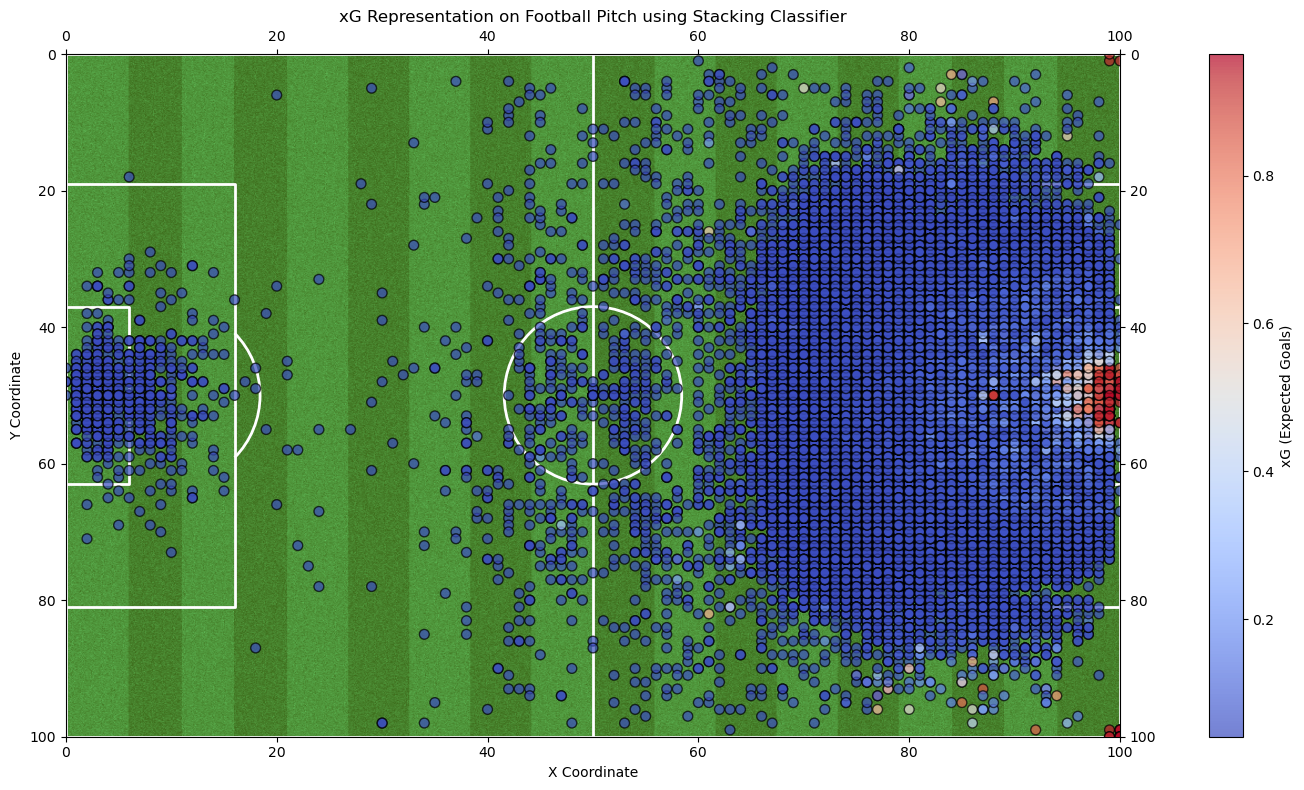

In [911]:
#  to plot xG values on a football pitch using xGBoost predictions

    # Create the pitch using the 'Pitch' object from the `mplsoccer` library
pitch = Pitch(pitch_color='grass', stripe=True, pitch_type='wyscout', line_color='white', goal_type='box', label=True, axis=True, tick=True)
fig, ax = pitch.draw(figsize=(18, 8))
    
    # Plot xG values on the football pitch as scatter points with color based on xG values
sc = ax.scatter(shots['X'] * 100, shots['Y'] * 100, c=shots['xG_calc_stack'], cmap='coolwarm', s=50, edgecolors='black', alpha=0.7)
    
    # Set the axis limits and labels
ax.set_xlim(0, 100)
ax.set_ylim(0, 100)
ax.set_xlabel('X Coordinate')
ax.set_ylabel('Y Coordinate')
ax.set_title('xG Representation on Football Pitch using Stacking Classifier')
    
    # Add colorbar
cbar = plt.colorbar(sc, ax=ax)
cbar.set_label('xG (Expected Goals)')
    
    # Invert y-axis to match the football pitch perspective
plt.gca().invert_yaxis()
    
plt.show()


In [647]:
# Filter shots that resulted in a goal and take the first 20 records
goals_df = shots[shots['is_goal'] == 1]

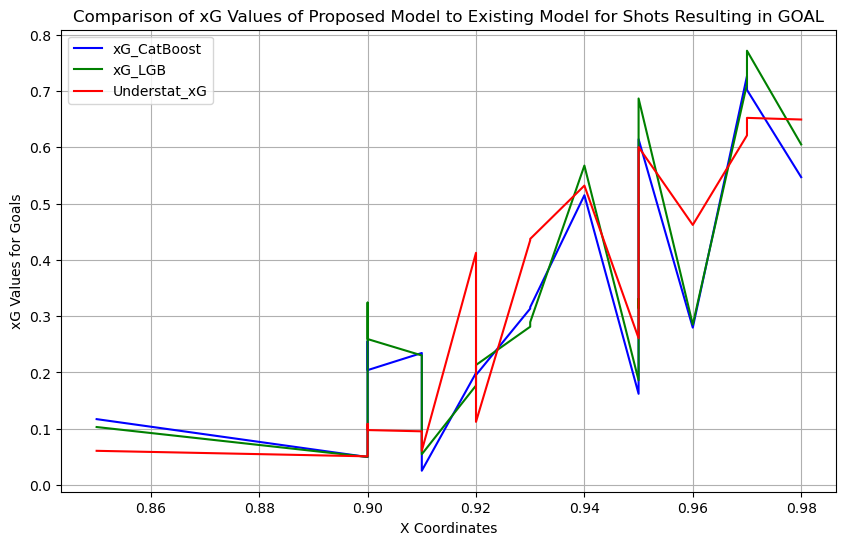

In [648]:
goals_df = goals_df.head(20)
goals_df = goals_df.sort_values(by=["X", "Y"])


# Create a line plot comparing xG values from different models for shots resulting in a goal
plt.figure(figsize=(10, 6))
plt.plot(goals_df['X'], goals_df['xG_calc_catboost'], label='xG_CatBoost', color='blue')
plt.plot(goals_df['X'], goals_df['xG_calc_LGB'], label='xG_LGB', color='green')
plt.plot(goals_df['X'], goals_df['xG'], label='Understat_xG', color='red')

# Customize the plot
plt.title('Comparison of xG Values of Proposed Model to Existing Model for Shots Resulting in GOAL')
plt.xlabel('X Coordinates')
plt.ylabel('xG Values for Goals')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

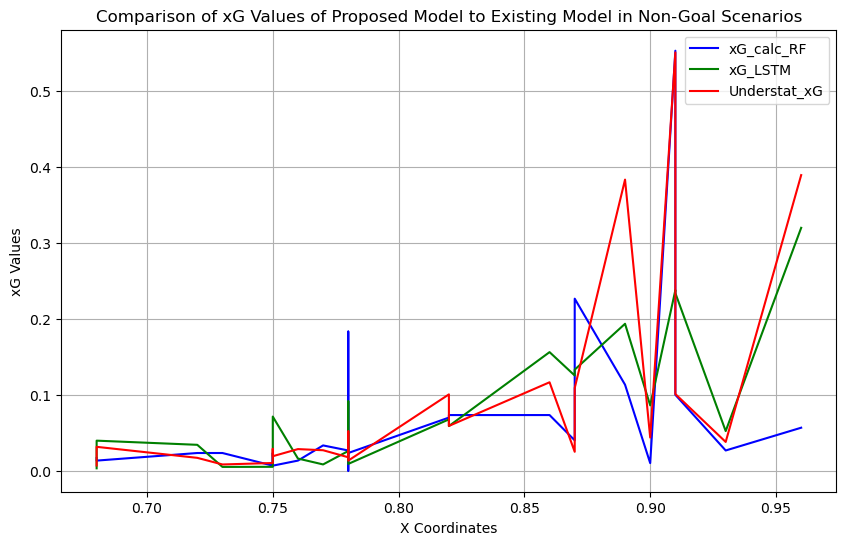

In [649]:
# Filter shots that did not result in a goal and take the last 25 records
non_goals_df = shots[shots['is_goal'] == 0]
non_goals_df = non_goals_df.tail(25)
non_goals_df = non_goals_df.sort_values(by=["X", "Y"])

# Create a line plot comparing xG values from different models for shots that did not result in a goal
plt.figure(figsize=(10, 6))
plt.plot(non_goals_df['X'], non_goals_df['xG_calc_RF'], label='xG_calc_RF', color='blue')
plt.plot(non_goals_df['X'], non_goals_df['xG_calc_LSTM'], label='xG_LSTM', color='green')
plt.plot(non_goals_df['X'], non_goals_df['xG'], label='Understat_xG', color='red')

# Customize the plot
plt.title('Comparison of xG Values of Proposed Model to Existing Model in Non-Goal Scenarios')
plt.xlabel('X Coordinates')
plt.ylabel('xG Values')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

In [658]:
#PERFORMANCE ANALYSIS

In [661]:
shots.columns

Index(['id', 'minute', 'result', 'X', 'Y', 'xG', 'player_striker', 'h_a',
       'player_id_striker', 'situation', 'season', 'shotType', 'match_id',
       'h_goals', 'a_goals', 'date', 'player_assisted', 'lastAction',
       'league_name_striker', 'league_id_striker', 'corrected_home_team',
       'corrected_away_team', 'id_unique_striker', 'fifa_version_striker',
       'long_name_striker', 'overall_striker', 'potential_striker',
       'age_striker', 'height_cm_striker', 'weight_kg_striker',
       'club_position_striker', 'preferred_foot_striker', 'weak_foot_striker',
       'skill_moves_striker', 'international_reputation_striker',
       'attacking_finishing_striker', 'attacking_heading_accuracy_striker',
       'attacking_volleys_striker', 'skill_fk_accuracy_striker',
       'movement_agility_striker', 'movement_reactions_striker',
       'movement_balance_striker', 'power_shot_power_striker',
       'power_jumping_striker', 'power_stamina_striker',
       'power_long_shots_stri

In [847]:
#CRYSTAL PALACE VS MANCHESTER UNITED 2020/21 SEASON
df_14768 = shots[shots['match_id'] == 14768]
df_14768 = df_14768.sort_values(by=["X", "Y"])  # Sorting by X and Y coordinates

# Create a DataFrame to store over/underperformance data
performance_analysis_df = pd.DataFrame(columns=['Player Name', 'Understat xG', 'Proposed xG', 'Total Goals'])

# Group by 'Player Name' and aggregate 'xG', 'Model xG', and 'Total Goals' columns
performance_analysis_df = df_14768.groupby('player_striker').agg({
    'xG': 'sum',             # Sum of Understat xG values
    'xG_calc_xgb': 'sum',     # Sum of xG values predicted by the proposed model (XGBoost model in this case)
    'is_goal': 'sum'          # Sum of goals scored by each player
}).reset_index()

# Rename columns to improve clarity
performance_analysis_df.columns = ['Player Name', 'Understat xG', 'Proposed Model xG', 'Total Goals']


--ANALYSIS OF CRYSTAL PALACE VS MANCHESTER UNITED 2020/21 SEASON ----------------------------------


Player Name  Understat xG  Proposed Model xG  Total Goals
0  Christian Benteke      0.179851           0.436117            0
1       Eberechi Eze      0.035171           0.037909            0
2      Ferrán Torres      0.132608           0.712374            1
3   Luka Milivojevic      0.050030           0.102411            0
4              Rodri      0.024063           0.040651            0
5      Sergio Agüero      0.363909           0.969831            1

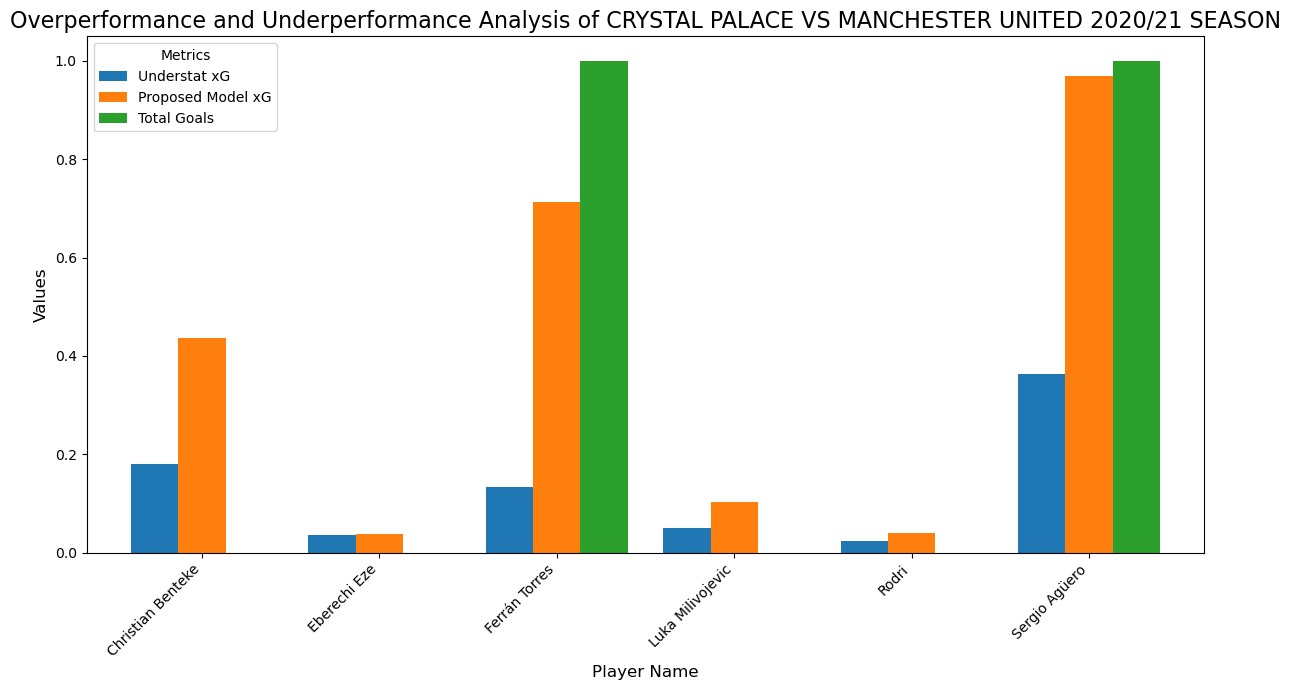



From the graph, it is evident that Ferrán Torres and Sergio Agüero have each scored 1 goal in the match. According to Understat’s xG values, Ferrán Torres had an xG of 0.132 and Sergio Agüero had an xG of 0.363. However, the proposed model estimates their xG values to be 0.71 for Ferrán Torres and 0.97 for Sergio Agüero, respectively.

Inference 1 - 
	Ferrán Torres has overperformed, scoring 1 goal, surpassing his proposed xG of 0.71.

Inference 2 - 
	Sergio Agüero has performed ideally by scoring 1 goal, closely matching his proposed xG of 0.97.

Inference 3 - 
	Christian Benteke has underperformed, with no goals despite a proposed xG of 0.44.


In [849]:
# Display the DataFrame to analyze the data
print("--ANALYSIS OF CRYSTAL PALACE VS MANCHESTER UNITED 2020/21 SEASON ----------------------------------")
display(performance_analysis_df)

# Set the player names as the index for better visualization in the bar plot
performance_analysis_df.set_index('Player Name', inplace=True)

# Plot the aggregated values for each player: Understat xG, Proposed Model xG, and Total Goals
ax = performance_analysis_df.plot(kind='bar', figsize=(12, 7), width=0.8)
ax.set_title('Overperformance and Underperformance Analysis of CRYSTAL PALACE VS MANCHESTER UNITED 2020/21 SEASON', fontsize=16)
ax.set_xlabel('Player Name', fontsize=12)
ax.set_ylabel('Values', fontsize=12)

# Adding data labels for better understanding of values on top of bars
#for container in ax.containers:
    #ax.bar_label(container, label_type='edge', fontsize=10)

# Rotating x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Adding legend and grid to the plot for clarity
plt.legend(title='Metrics', fontsize=10)

# Show the plot
plt.tight_layout()
plt.show()

print("\n\nFrom the graph, it is evident that Ferrán Torres and Sergio Agüero have each scored 1 goal in the match. According to Understat’s xG values, Ferrán Torres had an xG of 0.132 and Sergio Agüero had an xG of 0.363. However, the proposed model estimates their xG values to be 0.71 for Ferrán Torres and 0.97 for Sergio Agüero, respectively.\n")

print("Inference 1 - \n\tFerrán Torres has overperformed, scoring 1 goal, surpassing his proposed xG of 0.71.\n")
print("Inference 2 - \n\tSergio Agüero has performed ideally by scoring 1 goal, closely matching his proposed xG of 0.97.\n")
print("Inference 3 - \n\tChristian Benteke has underperformed, with no goals despite a proposed xG of 0.44.")

In [860]:
# BARCELONA VS ATHLETIC CLUB 2020/21 SEASON
df_14978 = shots[shots['match_id'] == 14978]
df_14978 = df_14978.sort_values(by=["X", "Y"])  # Sorting by X and Y coordinates

# Create a DataFrame to store over/underperformance data
performance_analysis_df = pd.DataFrame(columns=['Player Name', 'Understat xG', 'Proposed xG', 'Total Goals'])

# Group by 'Player Name' and aggregate 'xG', 'Model xG', and 'Total Goals' columns
performance_analysis_df = df_14978.groupby('player_striker').agg({
    'xG': 'sum',             # Sum of Understat xG values
    'xG_calc_xgb': 'sum',     # Sum of xG values predicted by the proposed model (XGBoost model in this case)
    'is_goal': 'sum'          # Sum of goals scored by each player
}).reset_index()

# Rename columns to improve clarity
performance_analysis_df.columns = ['Player Name', 'Understat xG', 'Proposed Model xG', 'Total Goals']


--ANALYSIS OF BARCELONA VS ATHLETIC CLUB 2020/21 SEASON ----------------------------------


Player Name  Understat xG  Proposed Model xG  Total Goals
0     Alex Berenguer      0.071488           0.043363            0
1  Antoine Griezmann      0.724428           0.985727            1
2       Lionel Messi      1.113125           0.949426            1
3        Raúl García      0.102026           0.357504            0
4      Ronald Araújo      0.036111           0.024549            0
5      Yeray Álvarez      0.052056           0.046385            0

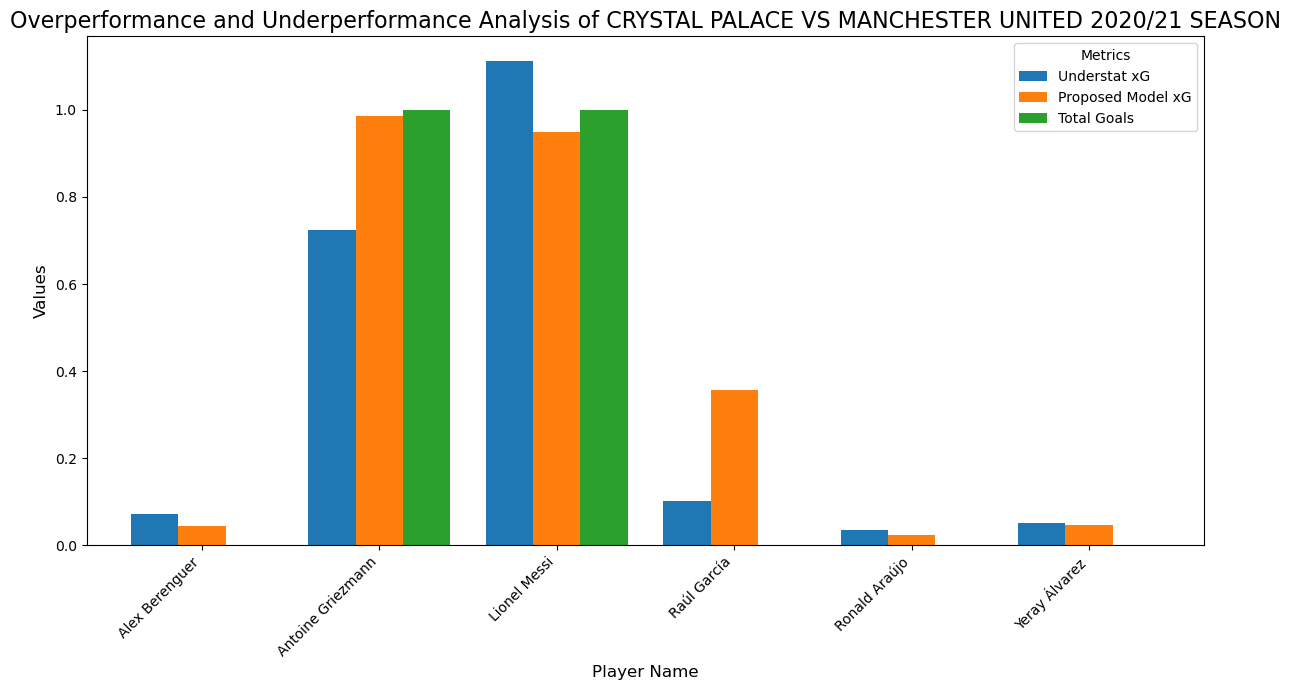



From the graph, it is evident that Antoine Griezmann and Lionel Messi have each scored 1 goal in the match. According to Understat’s xG values, Antoine Griezmann had an xG of 0.7 and Lionel Messi had an xG of 1.1. However, the proposed model estimates their xG values to be 0.99 for Antoine Griezmann and 0.95 for Lionel Messi, respectively.

Inference 1 - 
	Antoine Griezmann and Lionel Messi have performed ideally by scoring 1 goal, closely matching their proposed xG values.

Inference 2 - 
	Raúl García has underperformed, with no goals despite a proposed xG of 0.36.


In [862]:
# Display the DataFrame to analyze the data
print("--ANALYSIS OF BARCELONA VS ATHLETIC CLUB 2020/21 SEASON ----------------------------------")
display(performance_analysis_df)

# Set the player names as the index for better visualization in the bar plot
performance_analysis_df.set_index('Player Name', inplace=True)

# Plot the aggregated values for each player: Understat xG, Proposed Model xG, and Total Goals
ax = performance_analysis_df.plot(kind='bar', figsize=(12, 7), width=0.8)
ax.set_title('Overperformance and Underperformance Analysis of CRYSTAL PALACE VS MANCHESTER UNITED 2020/21 SEASON', fontsize=16)
ax.set_xlabel('Player Name', fontsize=12)
ax.set_ylabel('Values', fontsize=12)

# Adding data labels for better understanding of values on top of bars
#for container in ax.containers:
    #ax.bar_label(container, label_type='edge', fontsize=10)

# Rotating x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Adding legend and grid to the plot for clarity
plt.legend(title='Metrics', fontsize=10)
#plt.grid(True, axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()

print("\n\nFrom the graph, it is evident that Antoine Griezmann and Lionel Messi have each scored 1 goal in the match. According to Understat’s xG values, Antoine Griezmann had an xG of 0.7 and Lionel Messi had an xG of 1.1. However, the proposed model estimates their xG values to be 0.99 for Antoine Griezmann and 0.95 for Lionel Messi, respectively.\n")

print("Inference 1 - \n\tAntoine Griezmann and Lionel Messi have performed ideally by scoring 1 goal, closely matching their proposed xG values.\n")
print("Inference 2 - \n\tRaúl García has underperformed, with no goals despite a proposed xG of 0.36.")

In [834]:
# Grouping by 'Player Team' and aggregating xG and goals
team_performance_df = df_14978.groupby('playerTeam').agg({
    'xG': 'sum',               # Aggregating Understat xG
    'xG_calc_xgb': 'sum',       # Aggregating xG from the proposed model (XGBoost)
    'is_goal': 'sum'            # Aggregating total goals scored
}).reset_index()

# Renaming columns for better understanding
team_performance_df.columns = ['Team', 'Understat xG', 'Proposed xG Model', 'Total Goals']

# Displaying the dataframe for analysis
print("-------------- ANALYSIS OF BARCELONA VS ATHLETIC CLUB 2020/21 SEASON ------------------------------")
print(team_performance_df)

-------------- ANALYSIS OF BARCELONA VS ATHLETIC CLUB 2020/21 SEASON ------------------------------
            Team  Understat xG  Proposed xG Model  Total Goals
0  Athletic Club      0.275356           0.573219            0
1   FC Barcelona      2.543954           2.457051            2


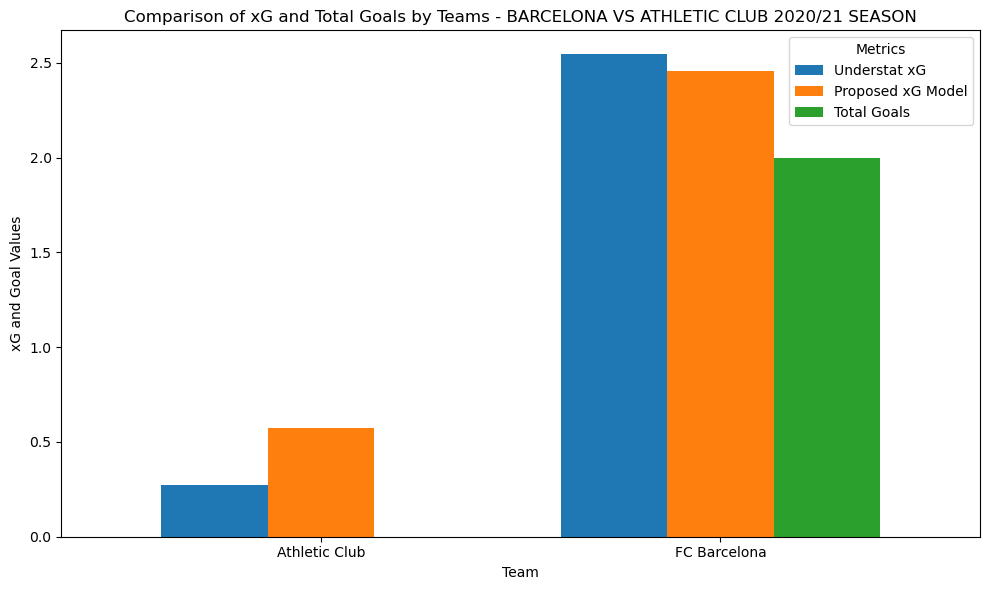



From the graph, it is evident that FC Barcelona had a proposed xG of 2.46, while Athletic Club had a proposed xG of 0.57. The final scoreline aligned with these predictions, with FC Barcelona scoring 2 goals and Athletic Club scoring none. (2 - 0)


In [835]:
# Set the index to 'Team' for plotting purposes
team_performance_df.set_index('Team', inplace=True)

# Plot the comparison of xG and total goals by team
team_performance_df.plot(kind='bar', figsize=(10, 6), width=0.8)

# Adding titles and labels to the plot for clarity
plt.title('Comparison of xG and Total Goals by Teams - BARCELONA VS ATHLETIC CLUB 2020/21 SEASON')
plt.xlabel('Team')
plt.ylabel('xG and Goal Values')

# Customizing x-axis rotation and legend
plt.xticks(rotation=0)
plt.legend(title='Metrics')

# Display the plot
plt.tight_layout()
#plt.grid(True)
plt.show()

print("\n\nFrom the graph, it is evident that FC Barcelona had a proposed xG of 2.46, while Athletic Club had a proposed xG of 0.57. The final scoreline aligned with these predictions, with FC Barcelona scoring 2 goals and Athletic Club scoring none. (2 - 0)")

In [ ]:
shots_streamlit = shots[['X', 'Y','Y_angle','player_striker','player_id_striker','id_unique_striker','playerTeam','season',
                         'is_Penalty', 'is_head','club_position_striker',
                         'is_home','is_OpenPlay','is_DirectFreekick','is_FromCorner','is_SetPiece','is_leading', 
                         'is_lagging', 'is_tied','overall_striker','Last_Action','attacking_finishing_striker',
                         'mentality_vision_striker','power_long_shots_striker','league_name_striker',
                         'opponentTeam','overall_defence_team','defence_defence_team','club_position_gk','long_name_gk',
                  'goalkeeping_reflexes_gk'
                 ]]

In [ ]:
shots.columns

In [ ]:
#shots_streamlit.to_excel("/Users/sp/Downloads/Dissertation/Datasets/shots_combined/shots_streamlit.xlsx")

In [ ]:
#checking with Journal

In [ ]:
#CATBOOST_check

In [650]:
# Initialize the CatBoostClassifier with parameters specified in the journal for testing
testing_catboost_model = CatBoostClassifier(random_state=42, learning_rate = 0.06, depth = 3)

# Fit the CatBoost model on the resampled and scaled training data
testing_catboost_model.fit(X_train_scaled_resampled, y_train_resampled)

# Make predictions and predict probabilities on the scaled test data
y_pred_proba = testing_catboost_model.predict_proba(X_test_scaled)[:, 1]
y_pred = testing_catboost_model.predict(X_test_scaled)

# Store the predictions in the test dataset for further analysis or visualization
X_test['test_catboost'] = y_pred

0:	learn: 0.6724787	total: 31.5ms	remaining: 31.5s
1:	learn: 0.6546816	total: 53.3ms	remaining: 26.6s
2:	learn: 0.6384059	total: 68.9ms	remaining: 22.9s
3:	learn: 0.6244938	total: 83.7ms	remaining: 20.8s
4:	learn: 0.6118478	total: 96ms	remaining: 19.1s
5:	learn: 0.6009051	total: 110ms	remaining: 18.1s
6:	learn: 0.5881665	total: 122ms	remaining: 17.3s
7:	learn: 0.5786909	total: 136ms	remaining: 16.9s
8:	learn: 0.5701158	total: 150ms	remaining: 16.6s
9:	learn: 0.5600127	total: 163ms	remaining: 16.1s
10:	learn: 0.5515304	total: 175ms	remaining: 15.7s
11:	learn: 0.5446202	total: 188ms	remaining: 15.5s
12:	learn: 0.5365648	total: 200ms	remaining: 15.2s
13:	learn: 0.5305013	total: 214ms	remaining: 15.1s
14:	learn: 0.5253692	total: 226ms	remaining: 14.9s
15:	learn: 0.5188660	total: 240ms	remaining: 14.8s
16:	learn: 0.4761181	total: 258ms	remaining: 14.9s
17:	learn: 0.4720702	total: 272ms	remaining: 14.9s
18:	learn: 0.4675206	total: 285ms	remaining: 14.7s
19:	learn: 0.4627915	total: 297ms	rema

In [651]:
# Print and calculate the evaluation metrics based on journal recommendations
print("Model Evaluation metrics - CATBOOST Model ")

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
precision = precision_score(y_test, y_pred)
print(f"Precision: {precision:.2f}")
recall = recall_score(y_test, y_pred)
print(f"Recall: {recall:.2f}")
#print(y_test,y_preds)
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC AUC: {roc_auc:.2f}")
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse:.2f}")
f1 = f1_score(y_test, y_pred)
print("F1 Score:", f1)
log_loss_val = log_loss(y_test, y_pred_proba)
print("Log Loss value :", log_loss_val)
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)
# r2 = r2_score(y_test, y_preds)
# print("R-squared:", r2)
brier_score = brier_score_loss(y_test, y_pred_proba)
print("Brier Score :", brier_score)


Model Evaluation metrics - CATBOOST Model 
Accuracy: 0.91
Precision: 0.65
Recall: 0.21
ROC AUC: 0.81
Mean Squared Error: 0.09
F1 Score: 0.3220858895705521
Log Loss value : 0.2663863046467484
Confusion Matrix:
 [[45543   611]
 [ 4251  1155]]
Brier Score : 0.07575921909068882


In [652]:
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae}")

Mean Absolute Error: 0.09429790535298681


In [ ]:
#streamlit -> model dump

In [361]:
# Saving the trained models to a pickle file for future use in the dashboard
joblib.dump(final_xgb_model, 'final_xgb_model.pkl')
joblib.dump(final_lgb_model, 'final_lgb_model.pkl')
joblib.dump(final_catboost_model,'final_catboost_model.pkl')
joblib.dump(stacking_clf, 'stacking_clf.pkl')
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

In [386]:
check=shots[shots['is_SetPiece']==1][['is_OpenPlay',
       'is_Penalty','is_SetPiece', 'is_DirectFreekick','is_FromCorner','is_head','Last_Action']]

In [387]:
check['Last_Action'].unique()

array([ 4,  3,  7, 10,  1,  9,  6,  5,  2,  0])

In [526]:
check_mes = shots[(shots['X'] > 0.84) & 
                  (shots['player_striker'] == 'Lionel Messi') & 
                  (shots['is_Penalty'] == 0) & 
                  (shots['defence_defence_team'] > 60) & 
                  (shots['defence_defence_team'] < 80)]

In [527]:
check_mes['is_goal'].value_counts()

is_goal
0    397
1    131
Name: count, dtype: int64